In [2]:
from lstm_models import LSTM, UtilizationLSTM
from gpu_dataloader import ForecastDataset, UtilizationDataset
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# plotting the data
import matplotlib.pyplot as plt
# used for the dataframes
import pandas as pd
from tqdm import tqdm

import random

from utils import get_device
from loss_classes import RMSELoss

import numpy as np
%matplotlib inline

from utils import get_device_as_string, get_device, get_rmse, get_mape, get_mae

In [3]:
batch_size: int = 1000
dataset = UtilizationDataset(small_df=True, batch_size=batch_size)
test_set = UtilizationDataset(is_training=False, small_df=True, batch_size=batch_size)

In [4]:
num_epochs: int = 30
learning_rate: float = 1e-3
bidirectional = False

# number of features
input_size: int = dataset.X.shape[2]
# number of features in hidden state
hidden_size: int = dataset.X.shape[2] * 1000
# number of stacked lstm layers
num_layers: int = 3
# number of output classes
num_classes: int = dataset.y.shape[1]
seq_length: int = dataset.X.shape[1]

device = get_device()

INCLUDE_WANDB: bool = False

In [5]:
dataset.y.shape

torch.Size([4000, 2])

In [6]:
if INCLUDE_WANDB == True:
    import wandb
    wandb.init(project='Hardware Utilization Prediction')

    wandb.config.num_epochs = num_epochs
    wandb.config.learning_rate = learning_rate
    wandb.config.input_size = input_size
    wandb.config.hidden_size = hidden_size
    wandb.config.num_layers = num_layers
    wandb.config.num_classes = num_classes

In [7]:
LOSS: str = 'loss'
RMSE_TRAINING: str = 'root mean squared error (training)'
MAE_TRAINING: str = 'mean absolute error (training)'

if INCLUDE_WANDB:
    wandb.define_metric(LOSS, summary='min')
    wandb.define_metric(RMSE_TRAINING, summary='min')
    wandb.define_metric(MAE_TRAINING, summary='min')

In [8]:
# lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length, bidirectional=bidirectional)
lstm = UtilizationLSTM(num_classes, input_size, hidden_size)
lstm.train()

# log gradients and model parameters
if INCLUDE_WANDB:
    wandb.watch(lstm)

lstm

UtilizationLSTM(
  (cpu_lstm): LSTM(2, 4000, batch_first=True)
  (mem_lstm): LSTM(2, 4000, batch_first=True)
  (cpu_lstm_seq): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=4000, out_features=2000, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=2000, out_features=1000, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=1000, out_features=1, bias=True)
  )
  (mem_lstm_seq): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=4000, out_features=2000, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): B

In [9]:
# mean square error for regression
# nn.
criterion = nn.MSELoss()
criterion = criterion.to(get_device())
# criterion = RMSELoss()
# criterion = criterion.to(device)
# optimizer function
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=50, factor=0.5, min_lr=1e-4, eps=1e-08)


In [10]:
def log_training_metrics(predictions, labels, loss):
    # logging to wandb
    if get_device_as_string() == 'cuda' or get_device_as_string() == 'mps':
        o = predictions.cpu().detach().numpy()
        l = labels.cpu().detach().numpy()
    else:
        o = predictions.detach().numpy()
        l = labels.detach().numpy()
    rmse = get_rmse(o, l)
    mae = get_mae(o, l)
    log_dict: dict = {
        LOSS: loss.item(),
        RMSE_TRAINING: rmse,
        MAE_TRAINING: mae,
    }
    wandb.log(log_dict)
    # print(log_dict)

In [11]:
def reorder_dataset(dataset: ForecastDataset, batch_size: int):
    batch_order = np.array([batch for batch in range(0, len(dataset), batch_size)], dtype=np.int32)
    batch_order = np.random.permutation(batch_order)

    dataset_order = np.empty(shape=[0, len(dataset.X)], dtype=np.int32)

    for batch in batch_order:
        if batch >= len(dataset) - (batch_size - 1):
            continue
        filled_batch_order = np.arange(batch, batch + batch_size, dtype=np.int32)
        dataset_order = np.append(dataset_order, filled_batch_order)
        
    dataset.X = dataset.X[dataset_order]
    dataset.y = dataset.y[dataset_order]

In [12]:
modulo_switch = num_epochs // 10
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=10)

loss_val = None
loss_progression: list = []
for epoch in (pbar := tqdm(range(0, num_epochs), desc=f'Training Loop (0) -- Loss: {loss_val}')):

    # if epoch % modulo_switch == modulo_switch - 1:
    #     reorder_dataset(dataset, batch_size // 2)
    #     train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    
    for _, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        predictions = lstm(inputs).to(device)

        optimizer.zero_grad()
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        
    if INCLUDE_WANDB:
        log_training_metrics(predictions, labels, loss)
    loss_val = loss.item()
    loss_progression.append(loss_val)
    pbar.set_description(f'Training Loop ({epoch + 1}) -- Loss: {loss_val:.5f}')
    
    with torch.no_grad():
        val_pred = lstm(test_set.X.to(device))
        val_loss = criterion(val_pred, test_set.y.to(device))
        scheduler.step(val_loss)
        


Training Loop (30) -- Loss: 0.00275: 100%|██████████| 30/30 [03:35<00:00,  7.17s/it]


<AxesSubplot:>

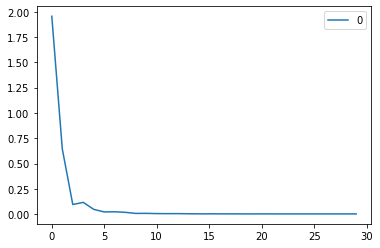

In [13]:
loss_df = pd.DataFrame(data=loss_progression)
loss_df.plot.line()

In [14]:
import time

current_time = time.ctime()
current_time

'Mon Oct 31 15:50:10 2022'

## Save the Model to Disk

In [15]:
lstm.eval()
model_name = f'models/epochs-{num_epochs}-{current_time}'

torch.save(
    {
        'epoch': num_epochs,
        'learning_rate': learning_rate,
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'num_classes': num_classes,
        'seq_length': seq_length,
        'model_state_dict': lstm.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        
    },
    f'{model_name}'
)


In [16]:
X_df = dataset.X
X_df = X_df.to(device)
# forward pass
prediction = lstm(X_df)
# prediction = prediction.reshape(1, -1)
if torch.has_cuda or torch.has_mps:
    prediction = prediction.cpu().detach().numpy()
else:
    prediction = prediction.data.numpy()

actual_data = dataset.y.data.numpy()
label_columns = dataset._get_label_columns()

# create dataframes
prediction_df = pd.DataFrame(prediction, columns=label_columns)
actual_data_df = pd.DataFrame(actual_data, columns=label_columns)

# reverse transformation
prediction_df = dataset.y_scaler.inverse_normalization_df(prediction_df)
actual_data_df = dataset.y_scaler.inverse_normalization_df(actual_data_df)


In [17]:
plan = X_df.cpu()
plan_df = dataset.X_scaler.convert_tensor_to_df(plan)
plan_df = dataset.X_scaler.inverse_standardize_df(plan_df)
plan_df = plan_df[['plan_cpu']]
plan_df

,plan_cpu
0,400.0
1,600.0
2,600.0
3,600.0
4,600.0
...,...
3995,600.0
3996,600.0
3997,600.0
3998,600.0


In [18]:
combined_df = pd.merge(actual_data_df, prediction_df, left_index=True, right_index=True)
# combined_df.rename()
combined_df['plan_cpu'] = plan_df

combined_df = combined_df.rename(columns={'cpu_usage_x': 'actual cpu usage', 'cpu_usage_y': 'predicted cpu usage', 'plan_cpu': 'allocated cpu'})


<AxesSubplot:>

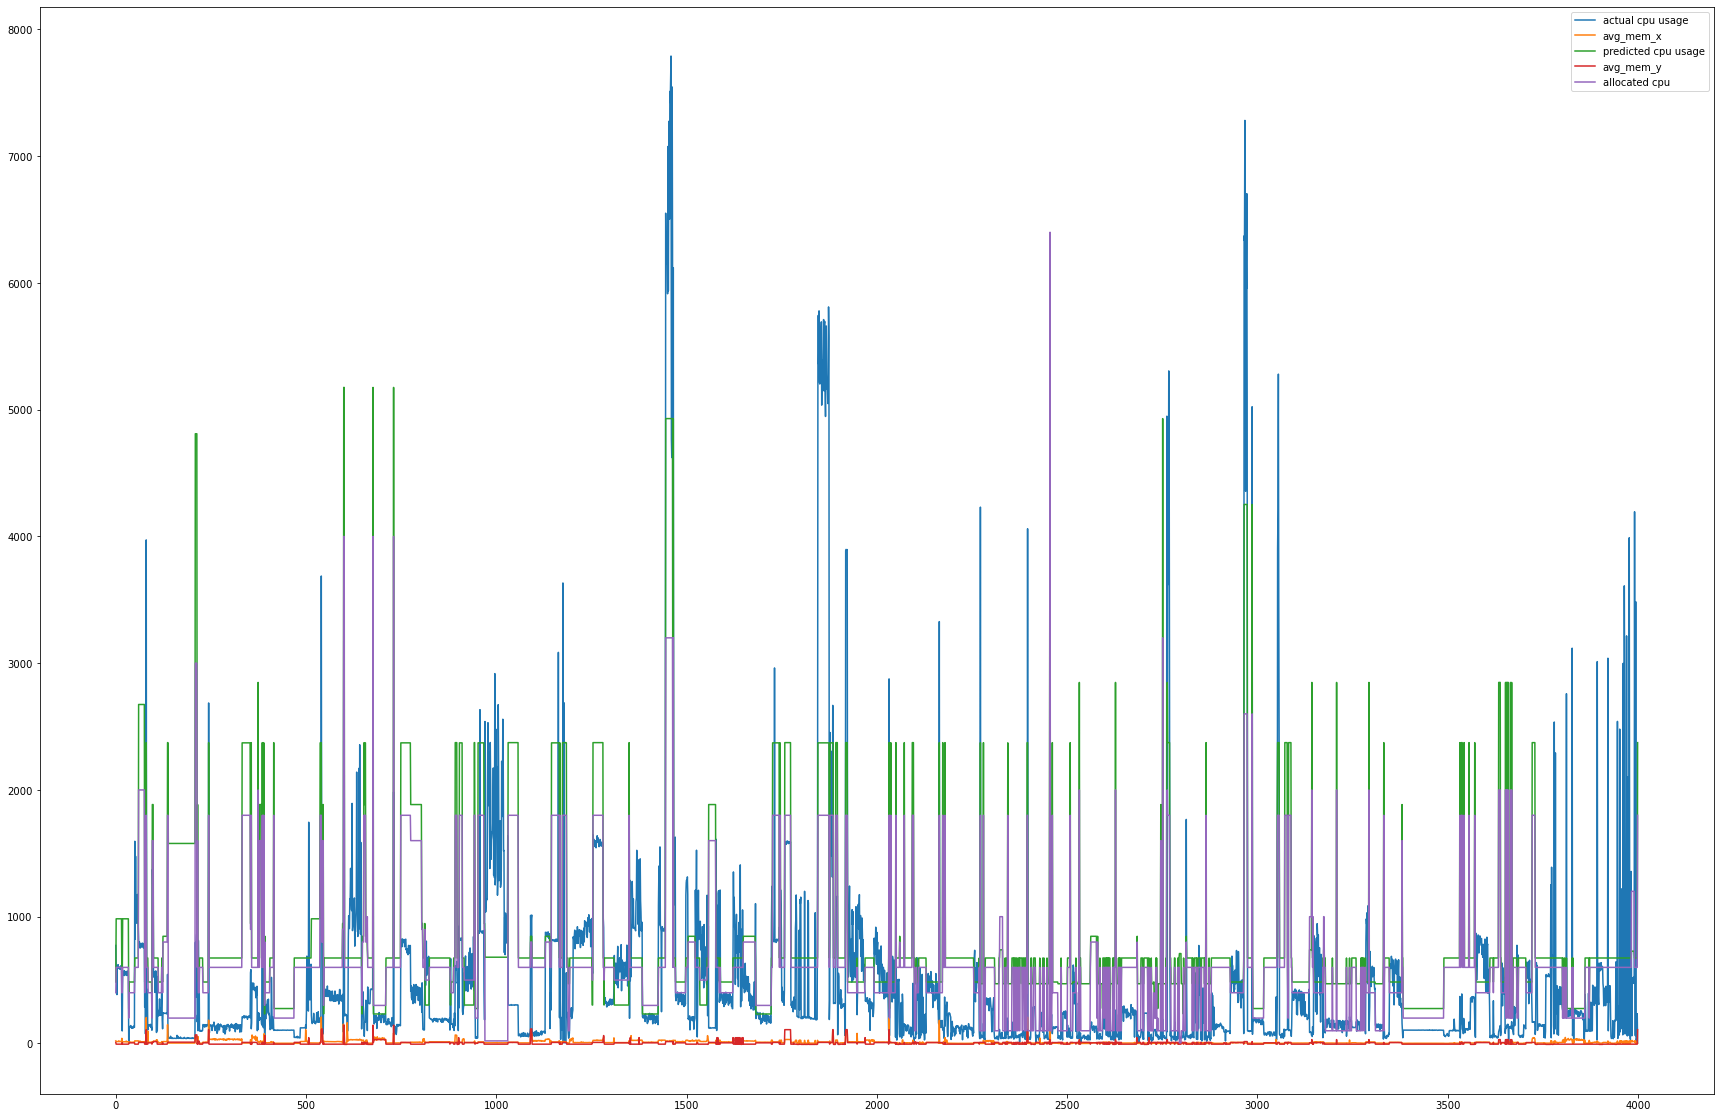

In [19]:
combined_df.plot.line(figsize=(30, 20))

<AxesSubplot:>

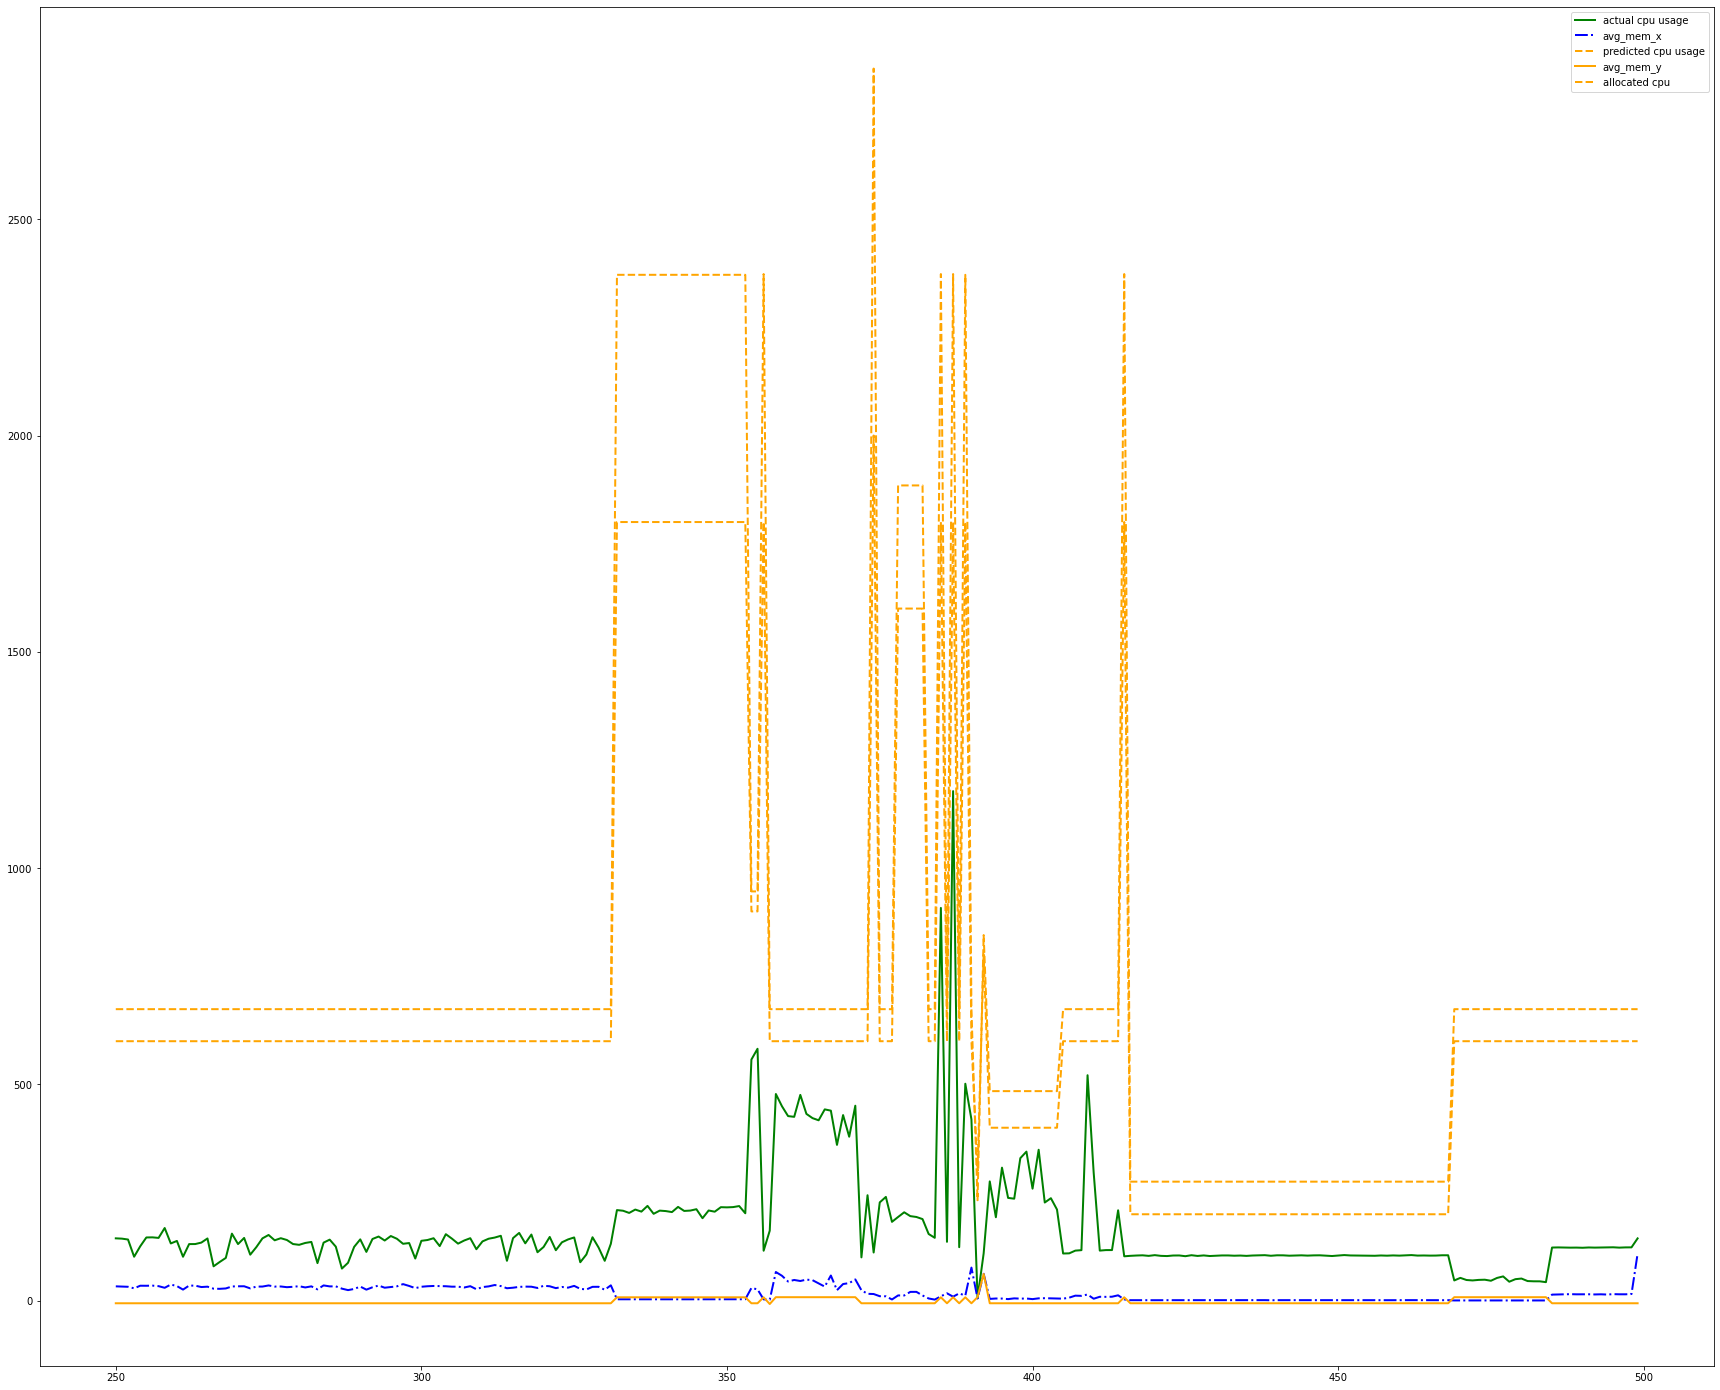

In [20]:
cycler = plt.cycler(linestyle=['-', '-.', '--', '-', '--', '-', '--'],
                    color=['green', 'blue', 'orange', 'orange', 'orange', 'green', 'green'],
)
fig, ax = plt.subplots()
ax.set_prop_cycle(cycler)


combined_df.iloc[250:500].plot(ax=ax, figsize=(30, 25), linewidth=2)


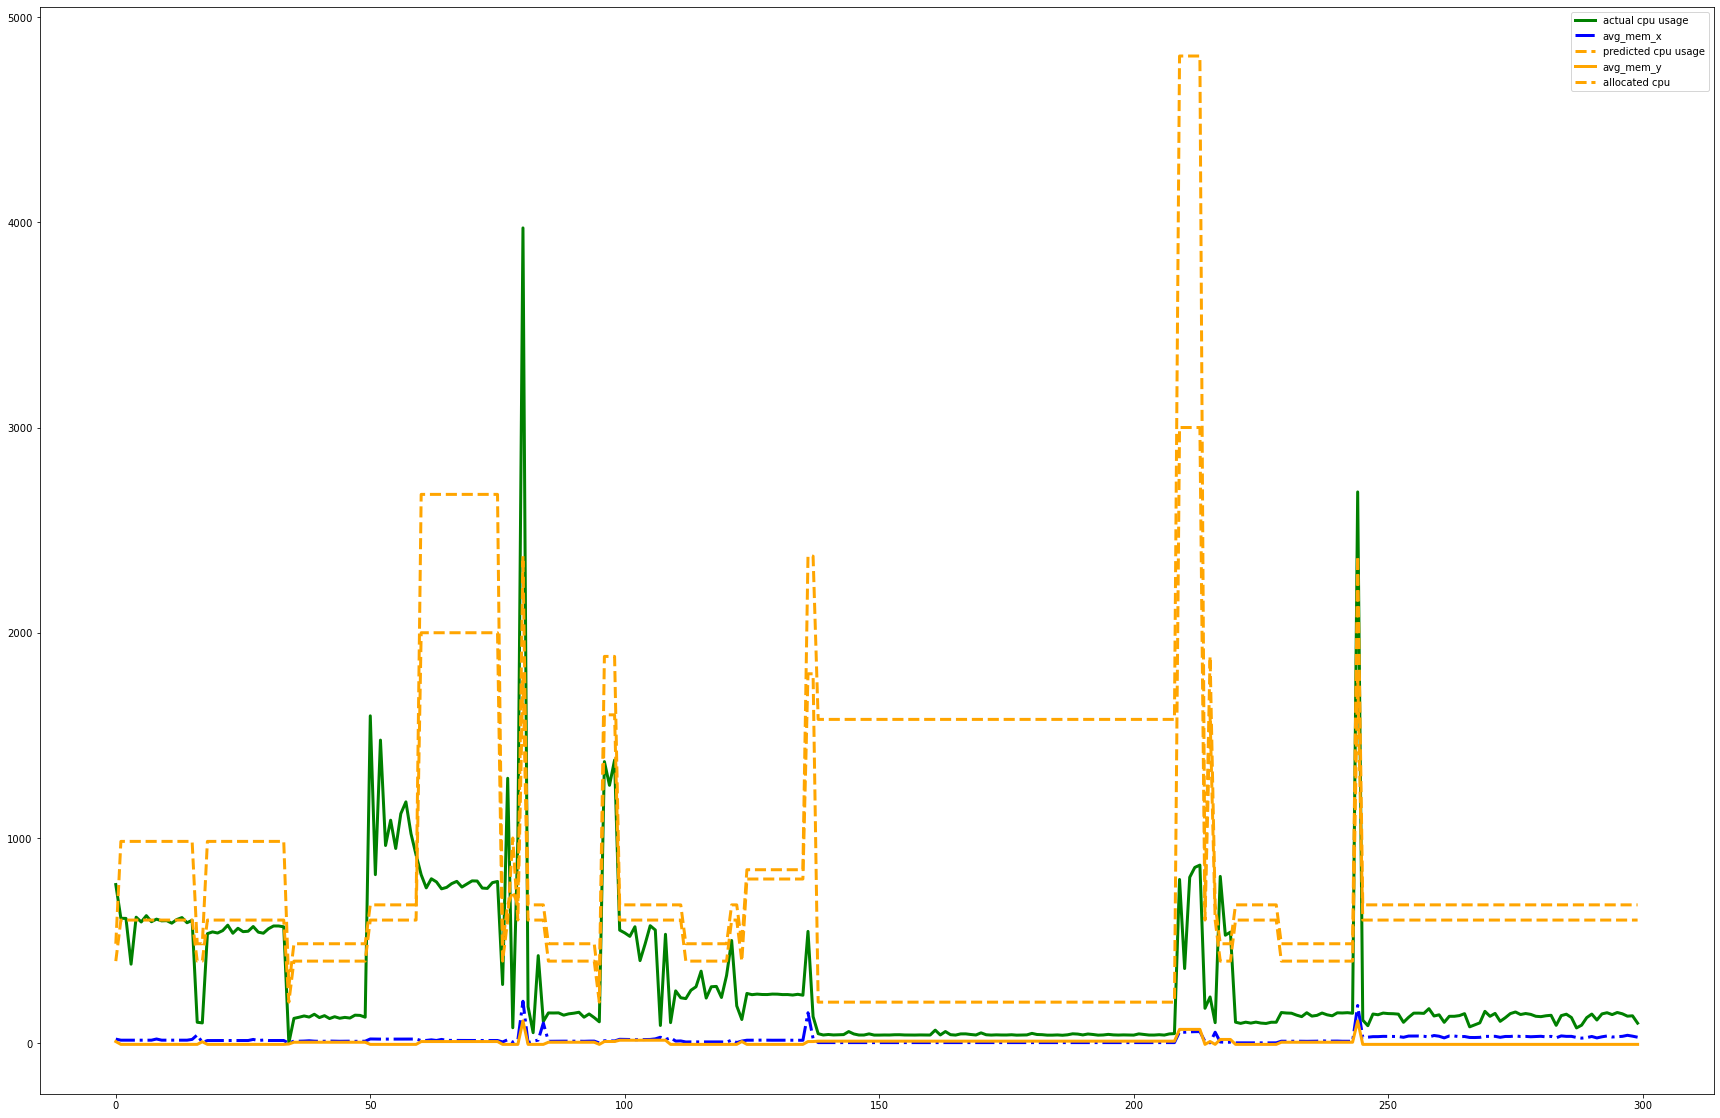

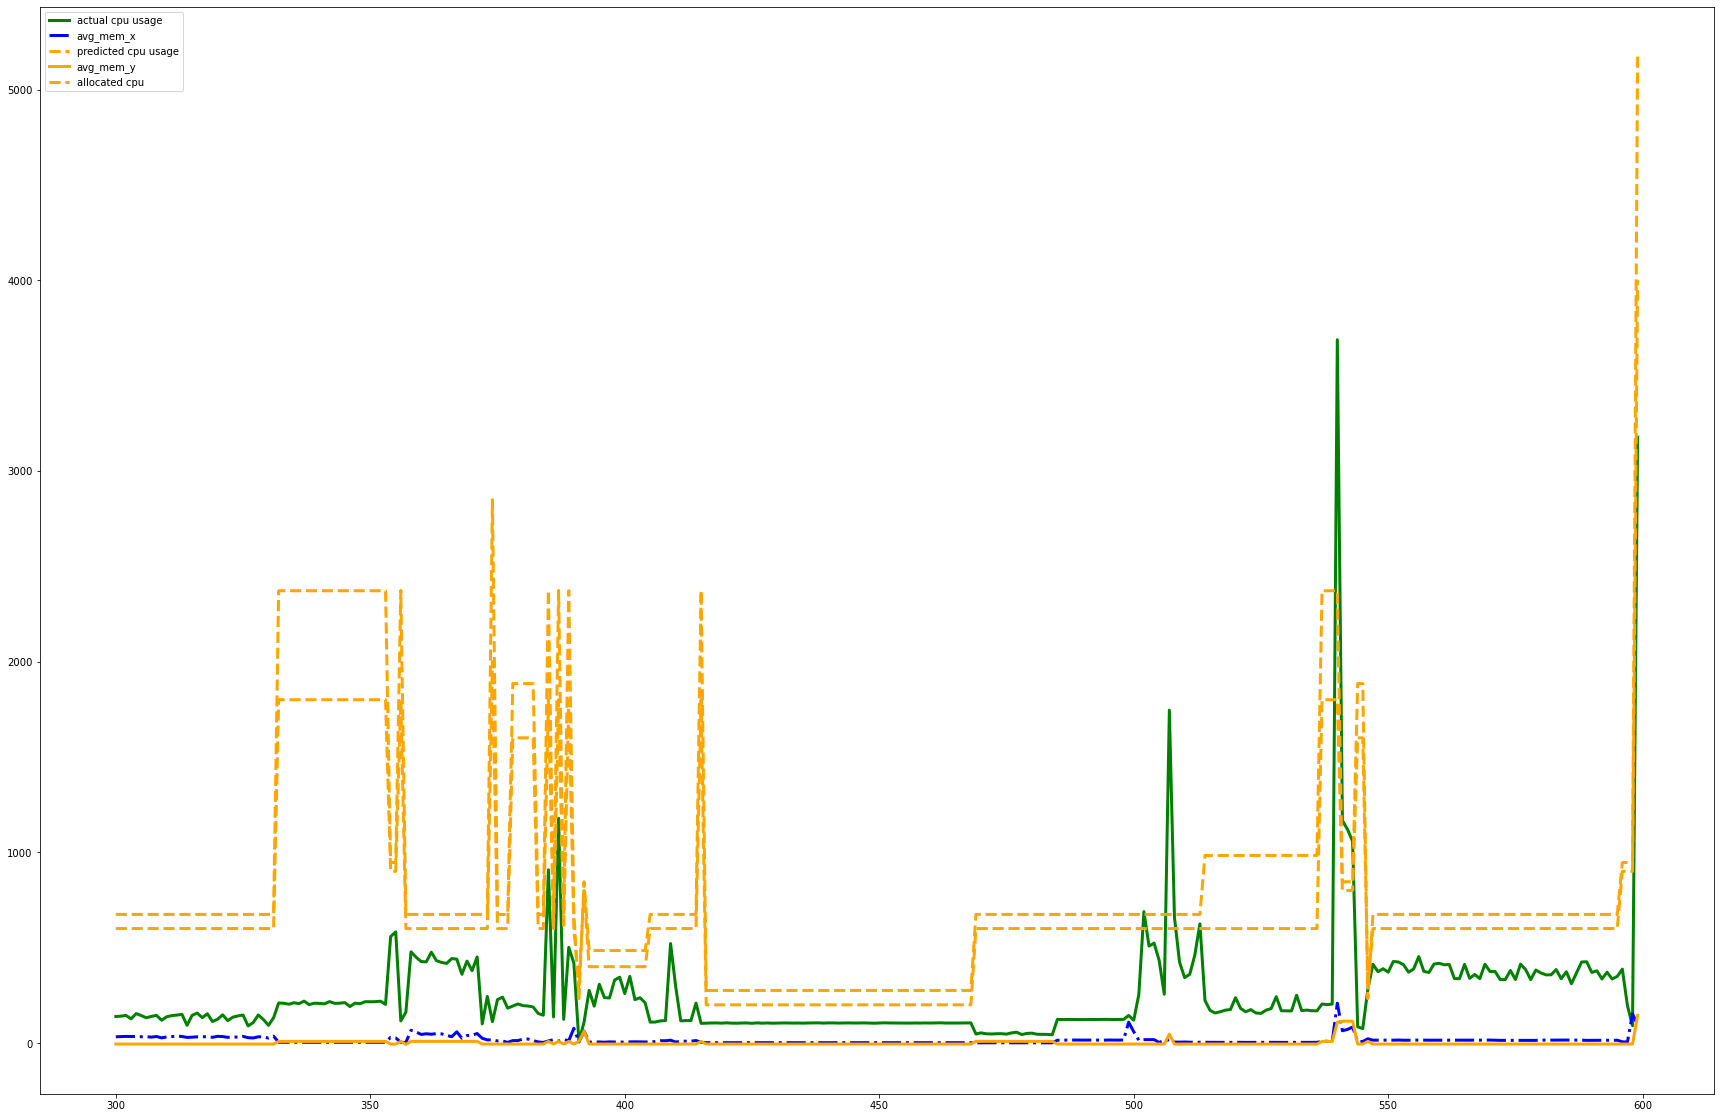

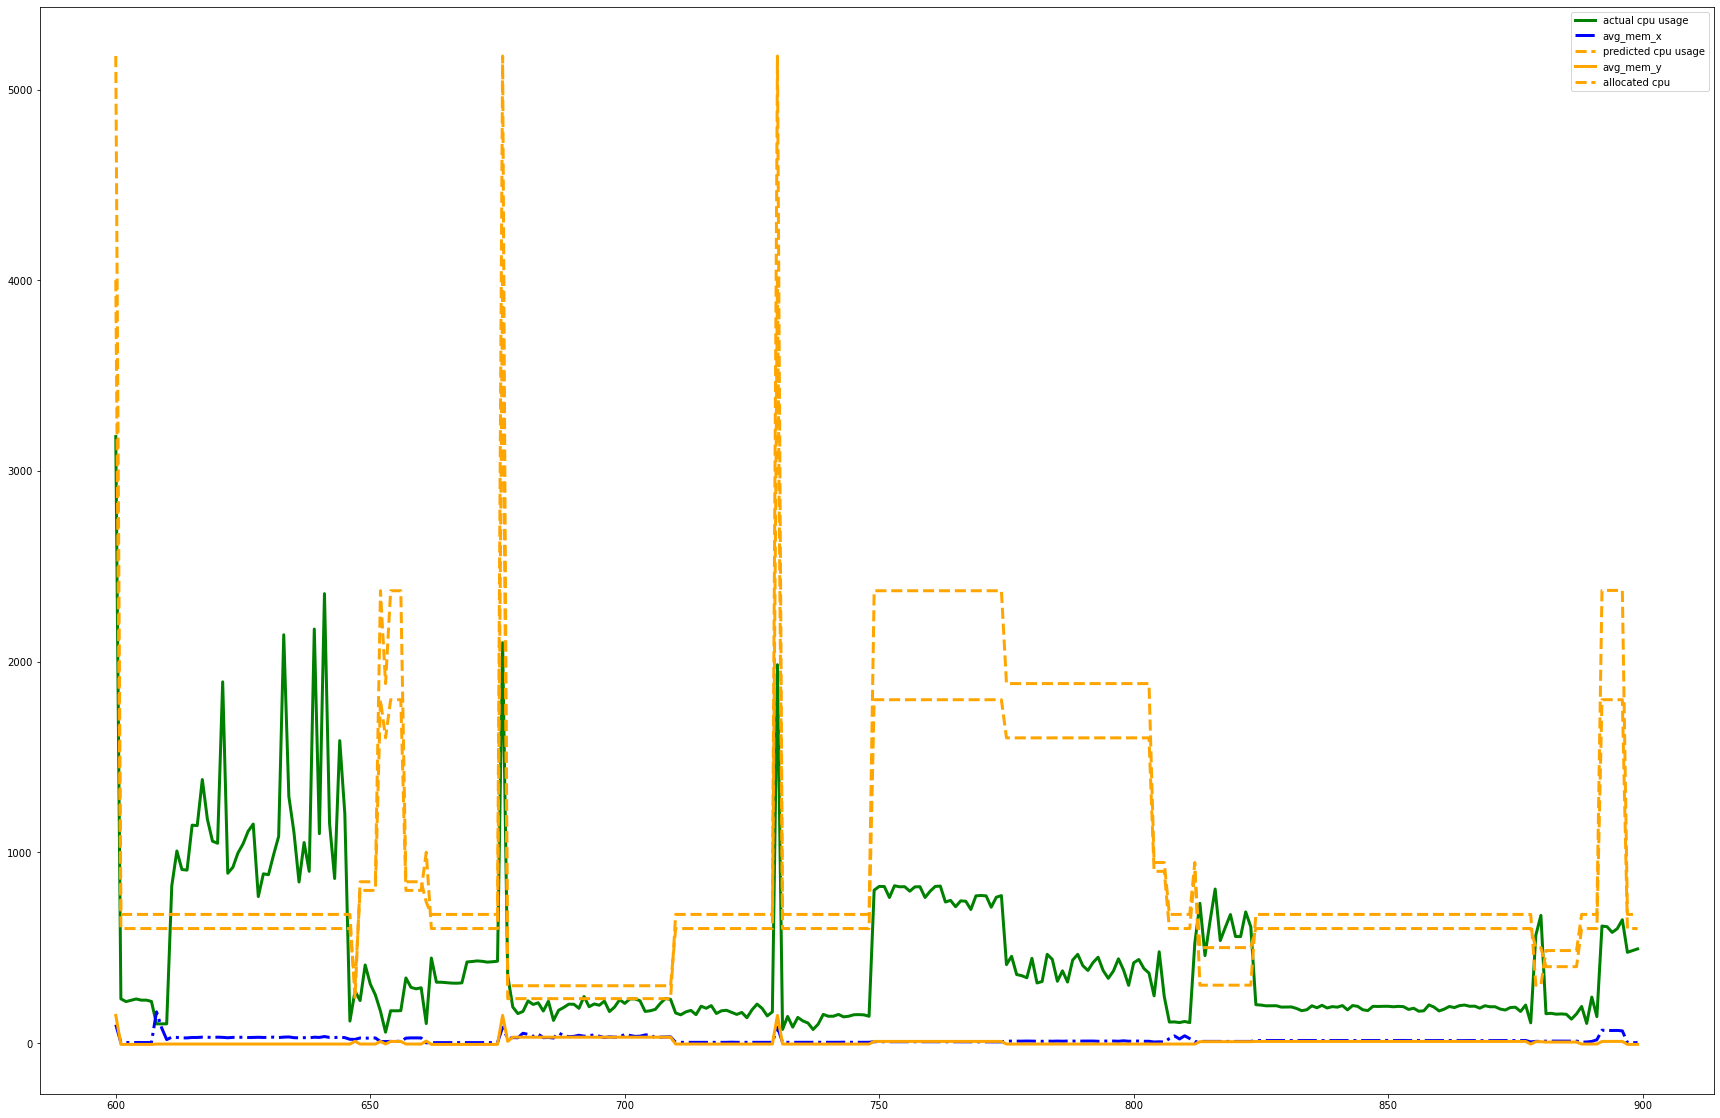

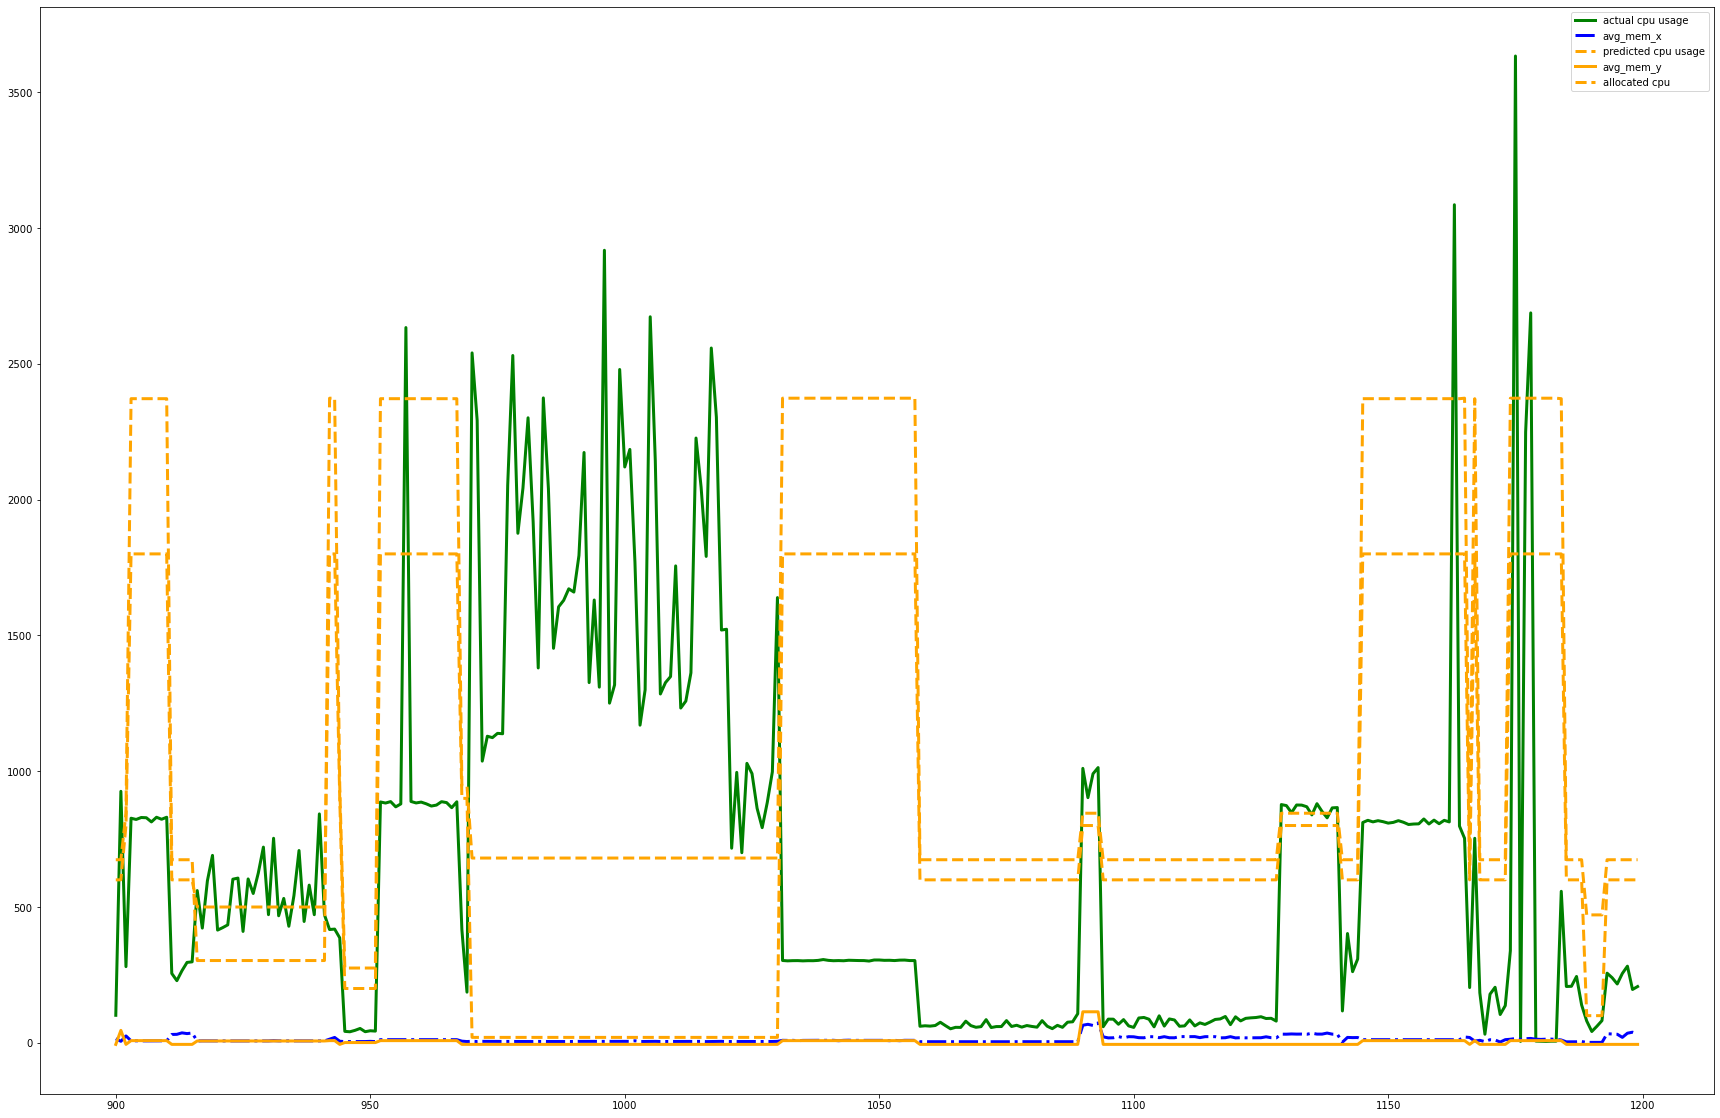

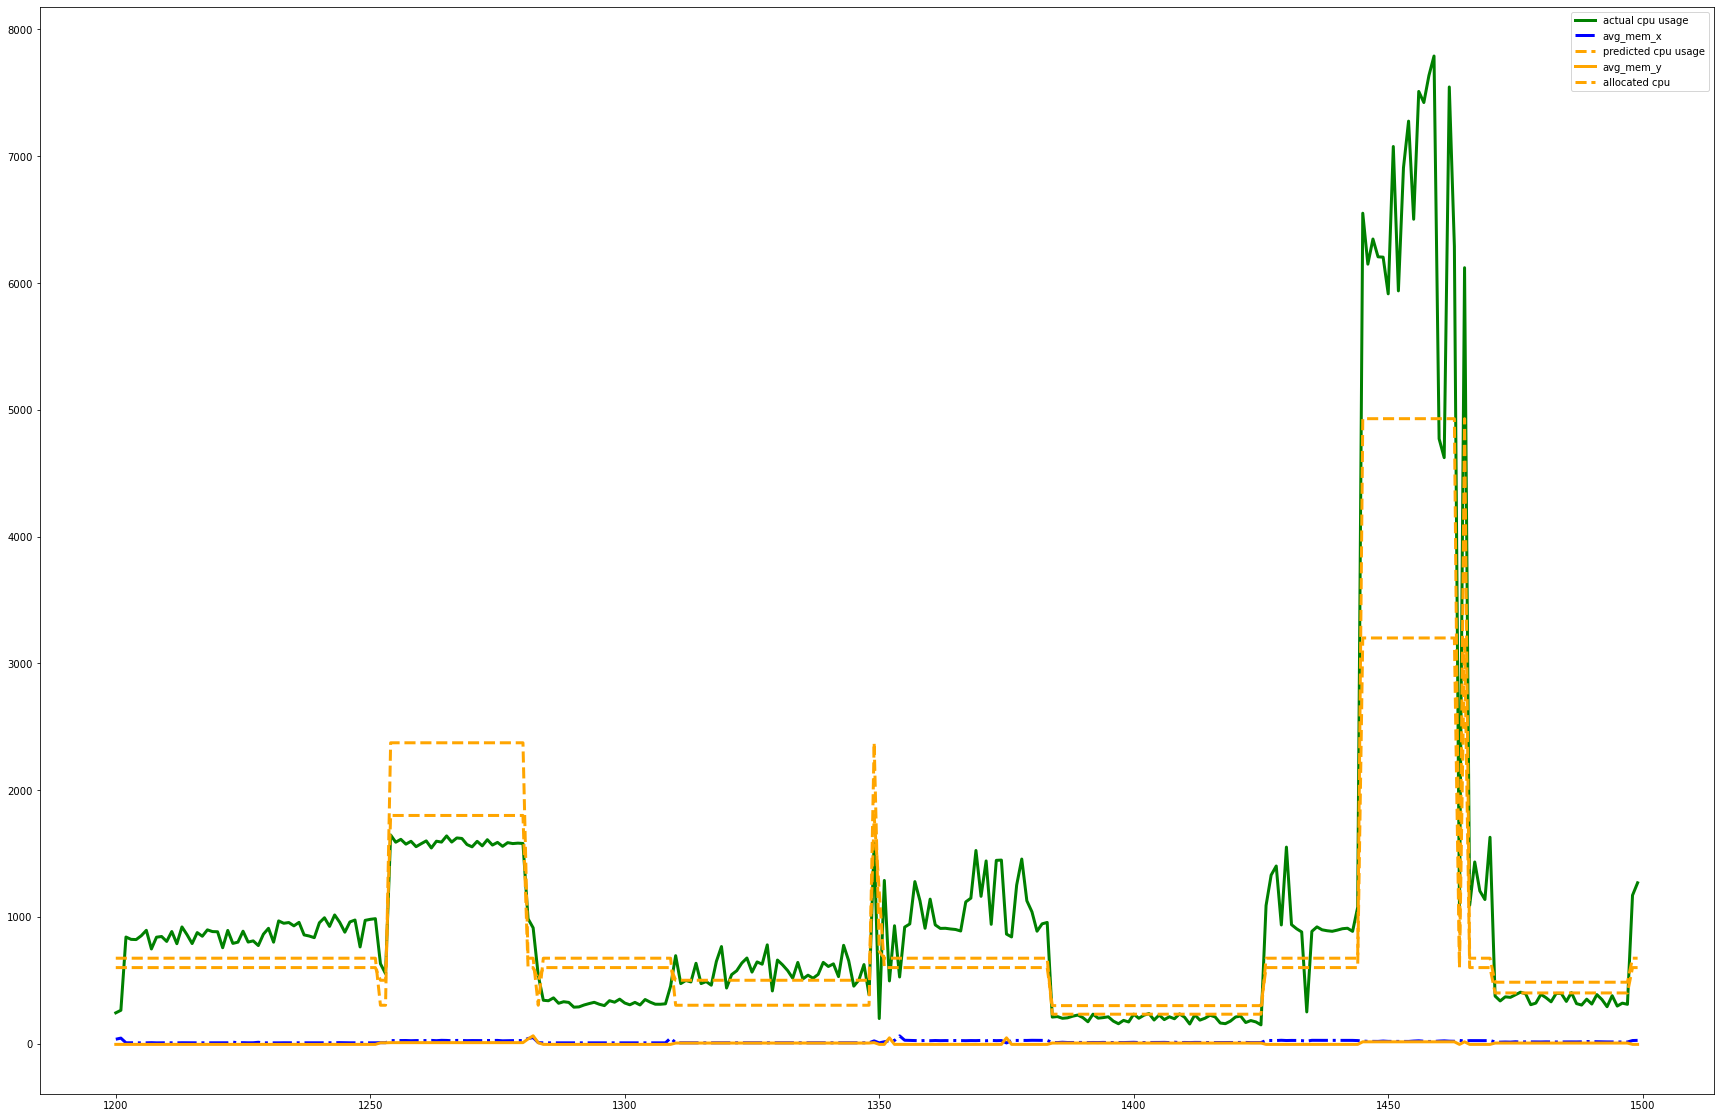

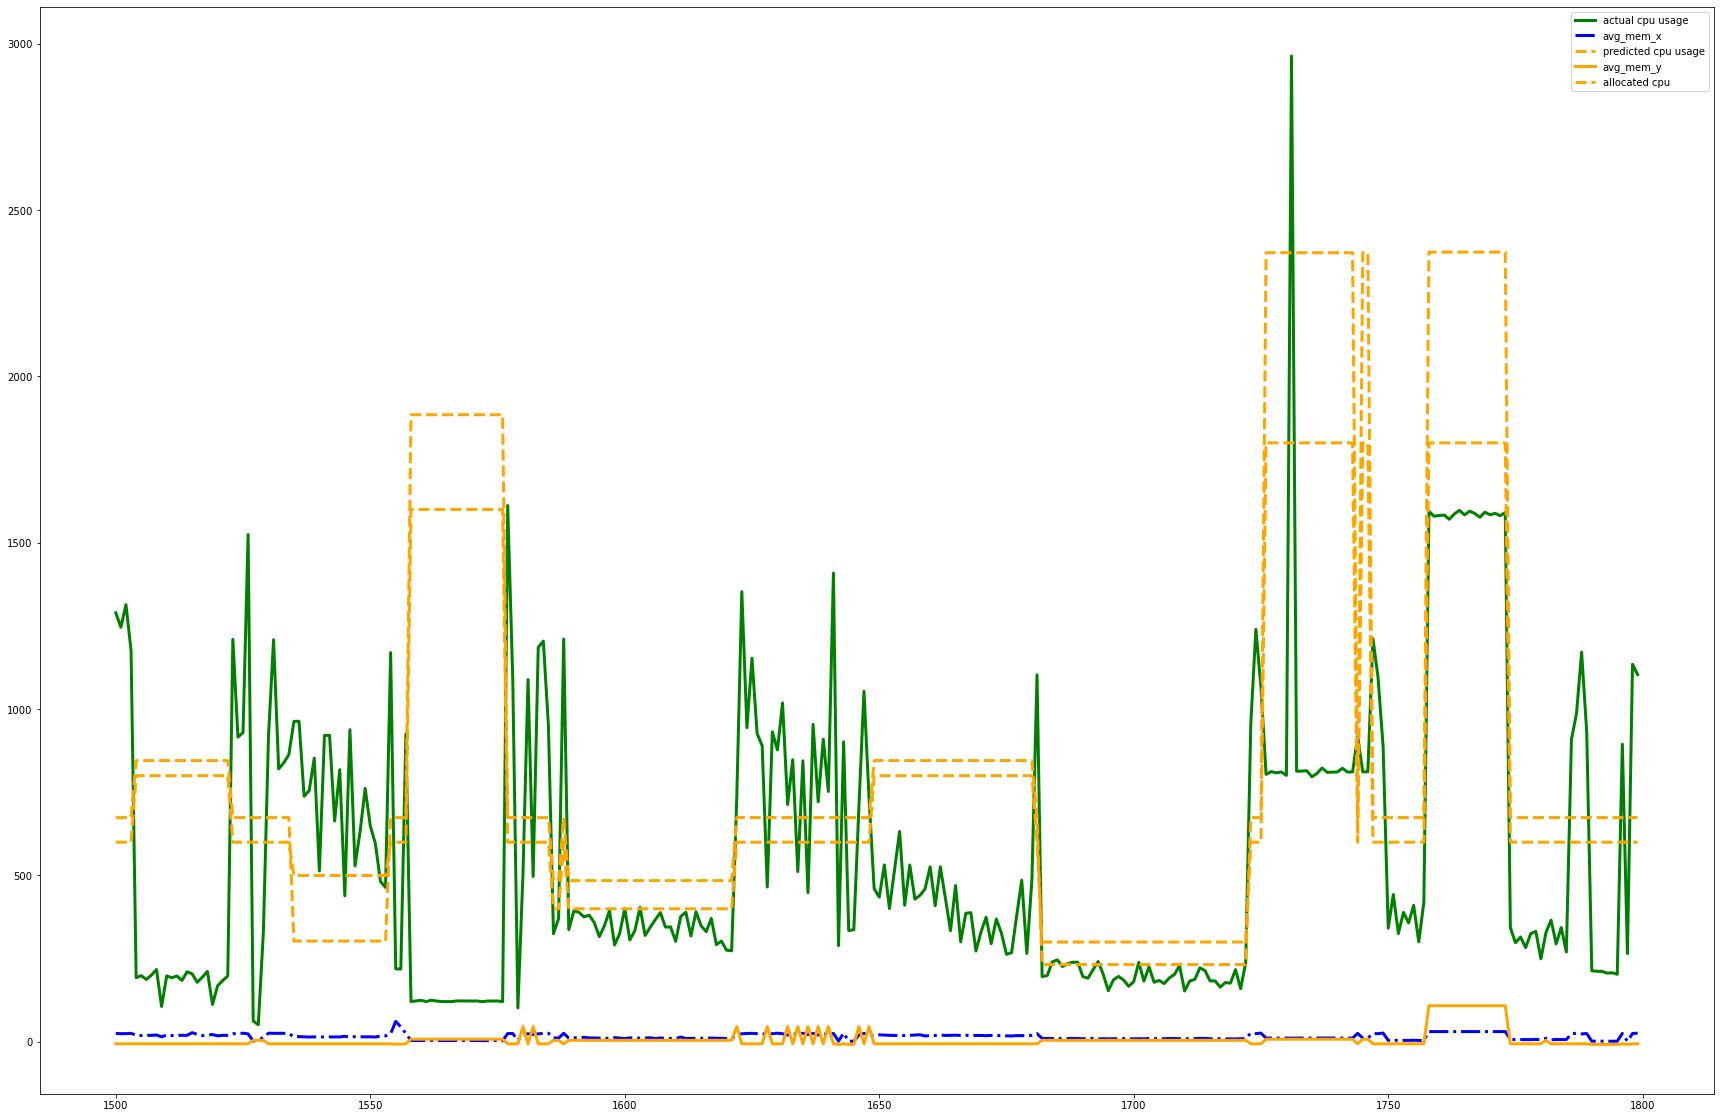

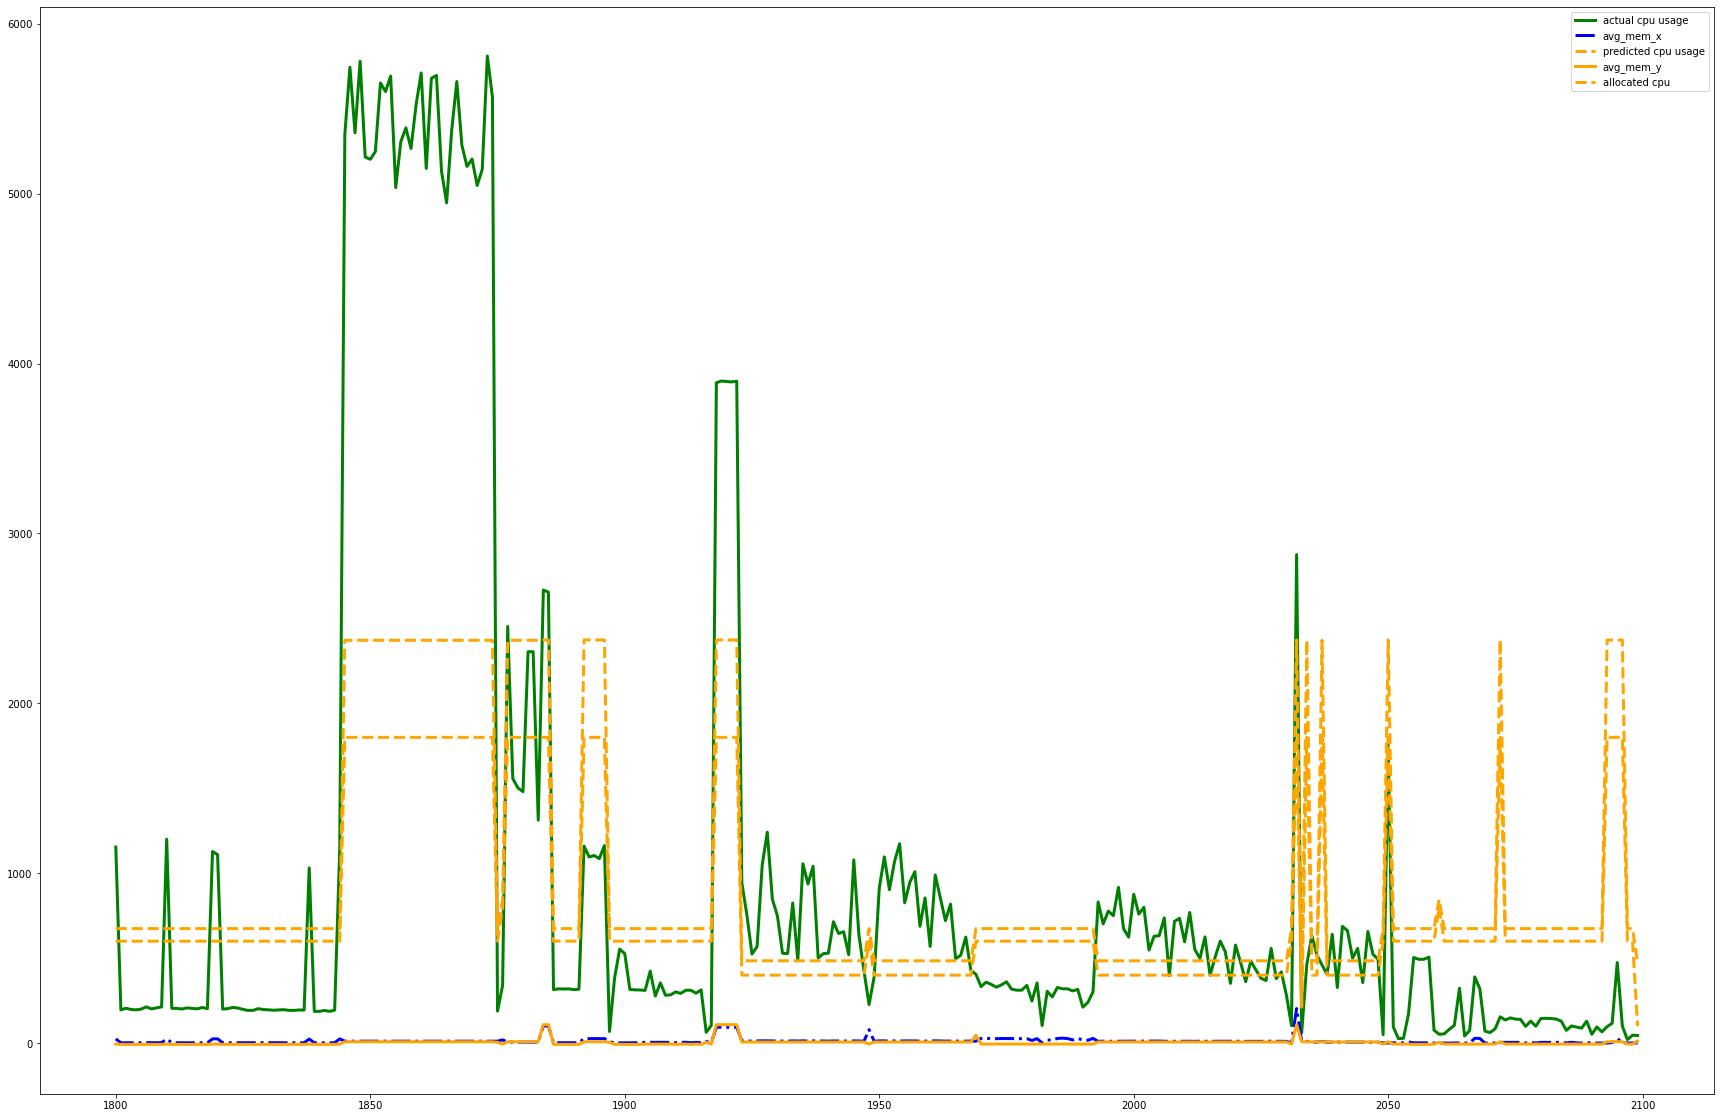

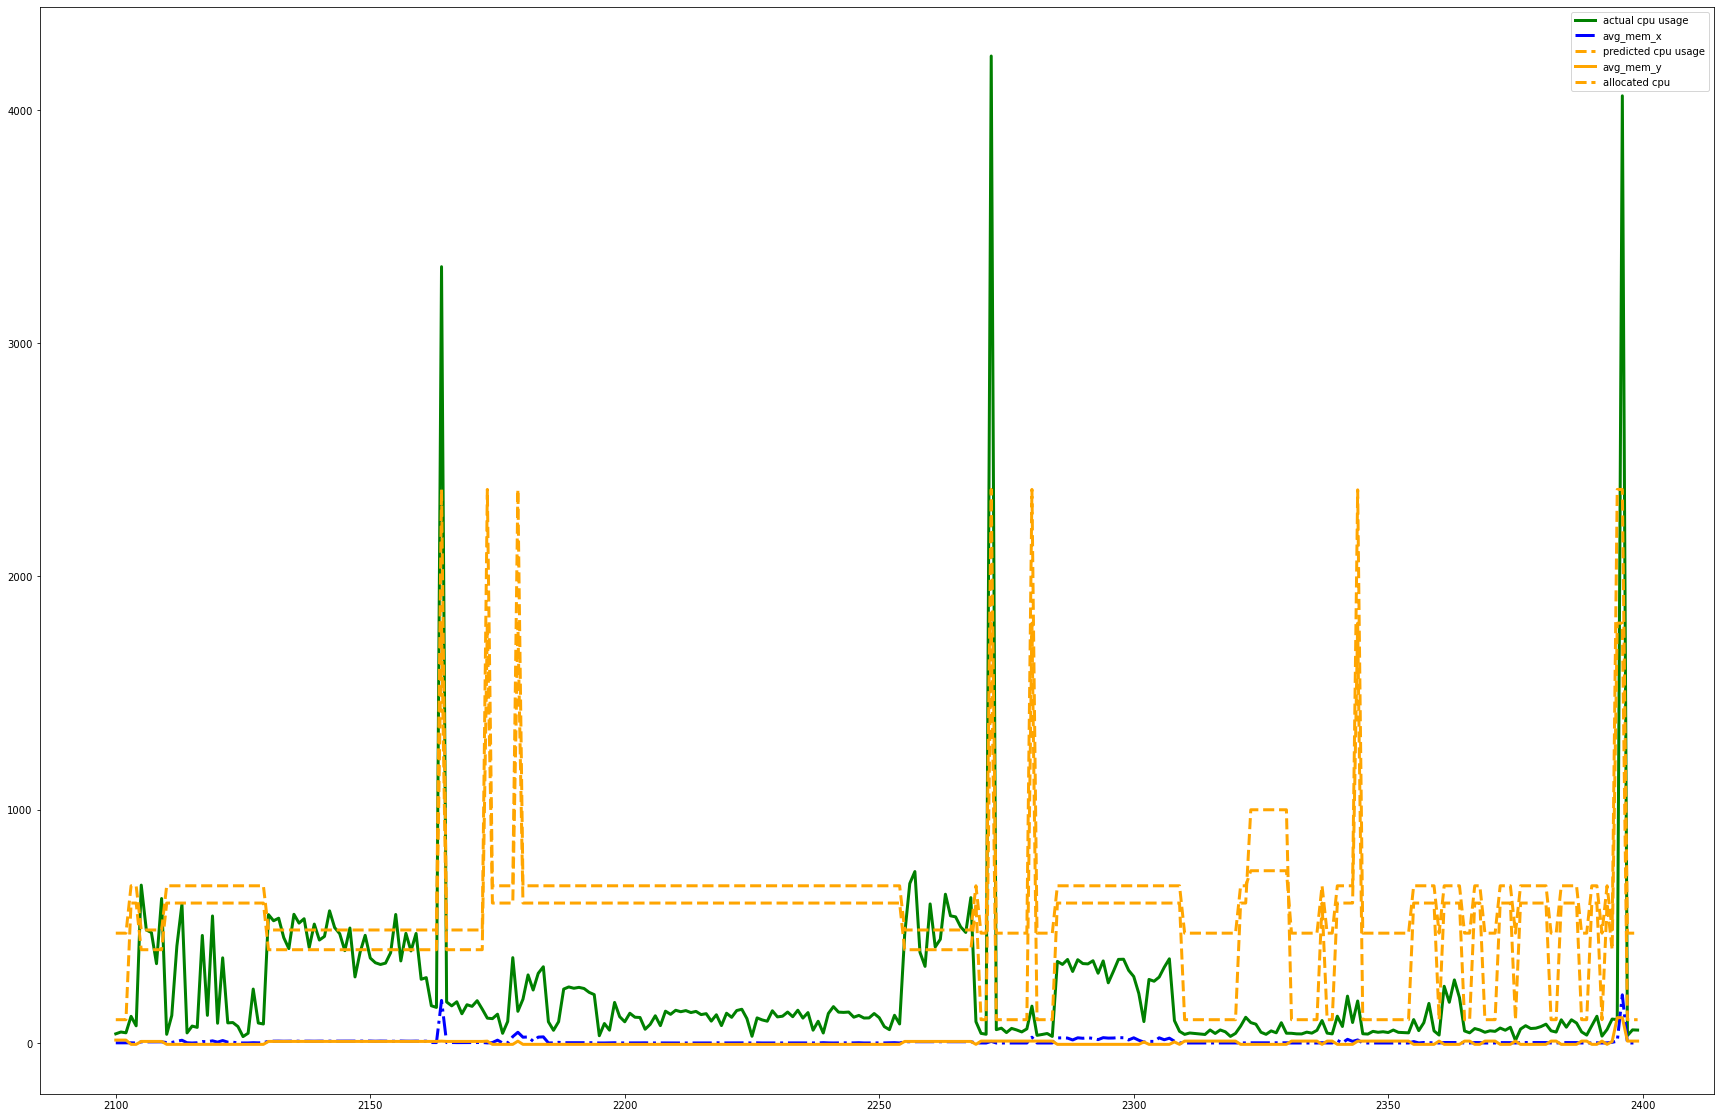

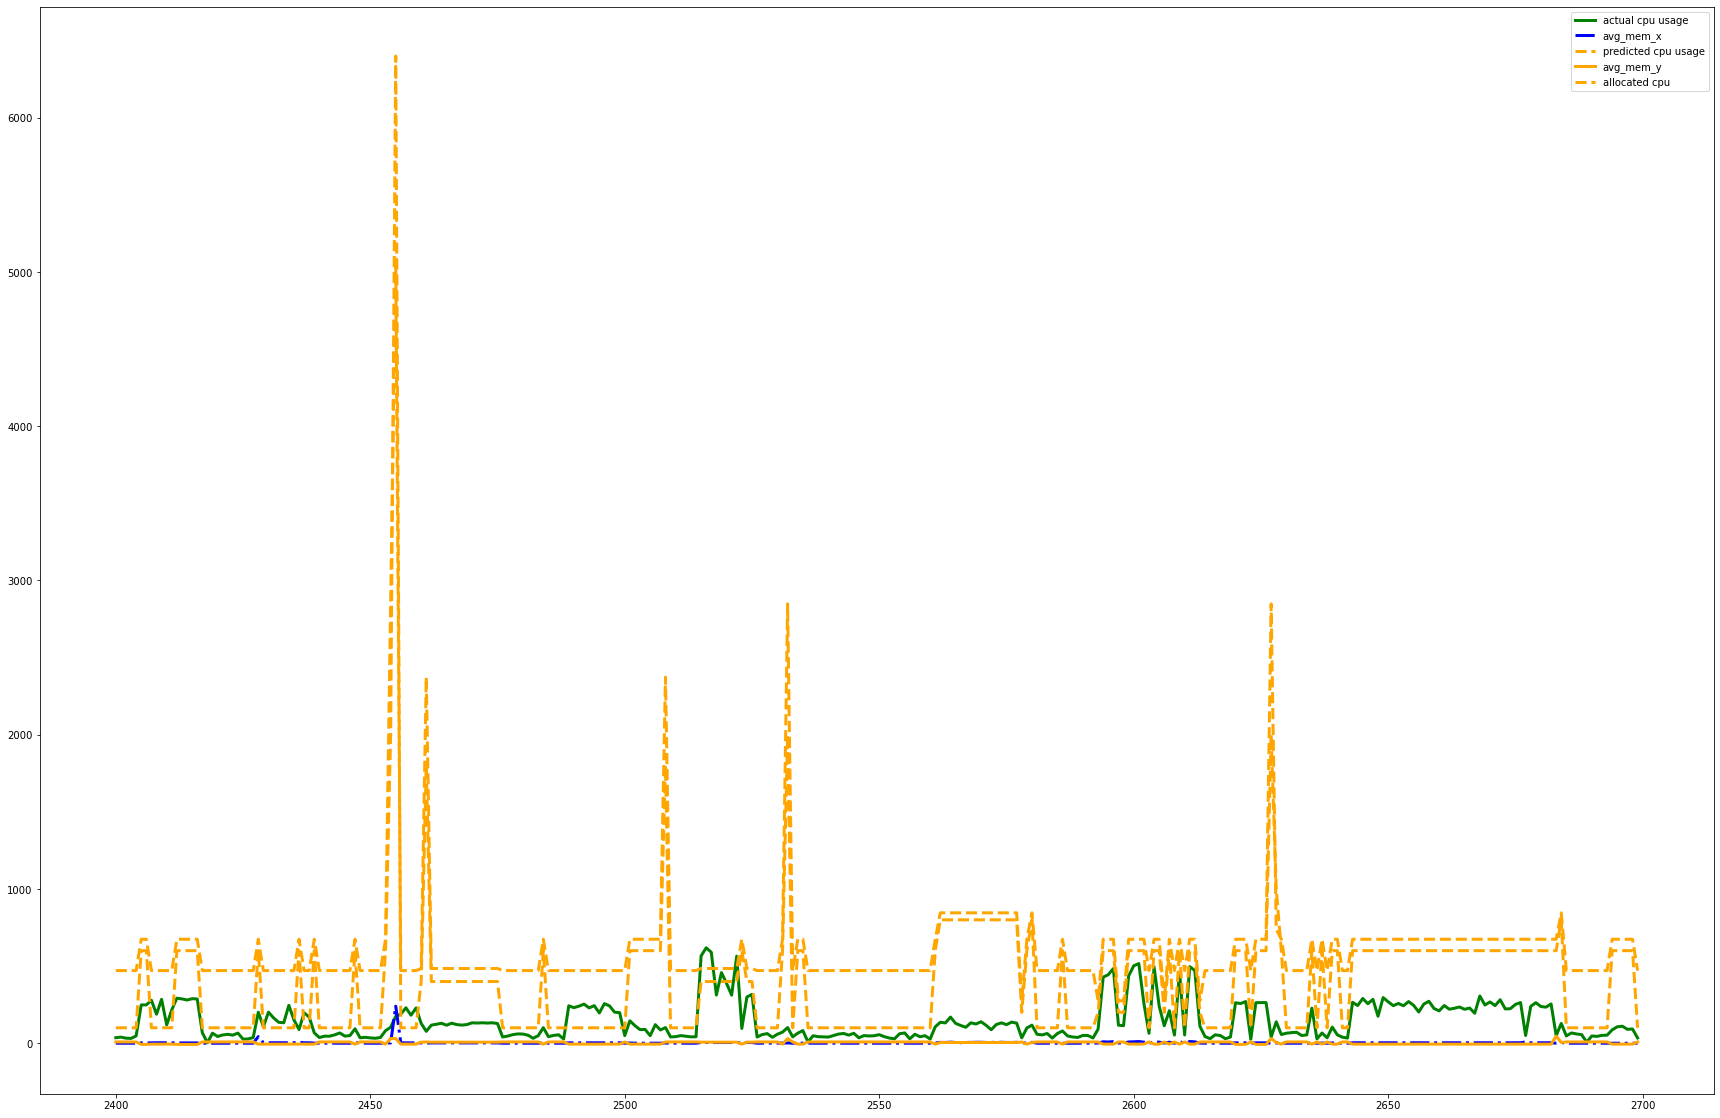

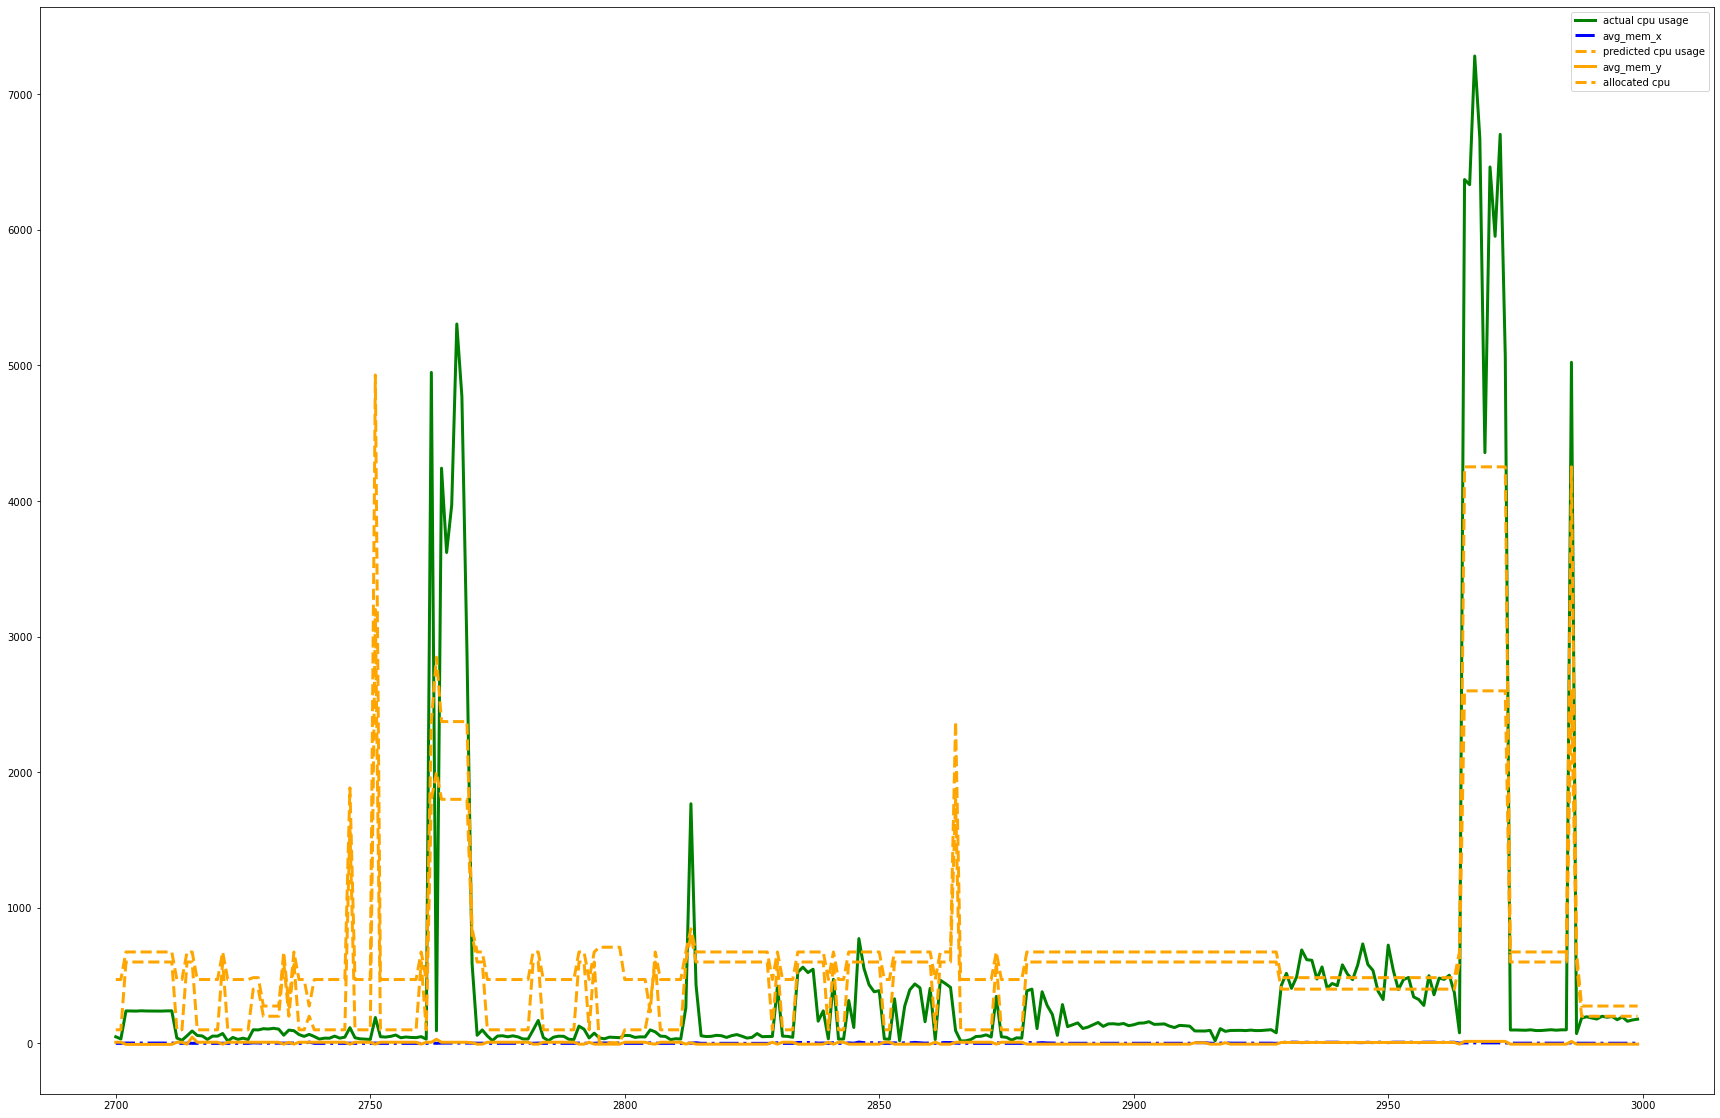

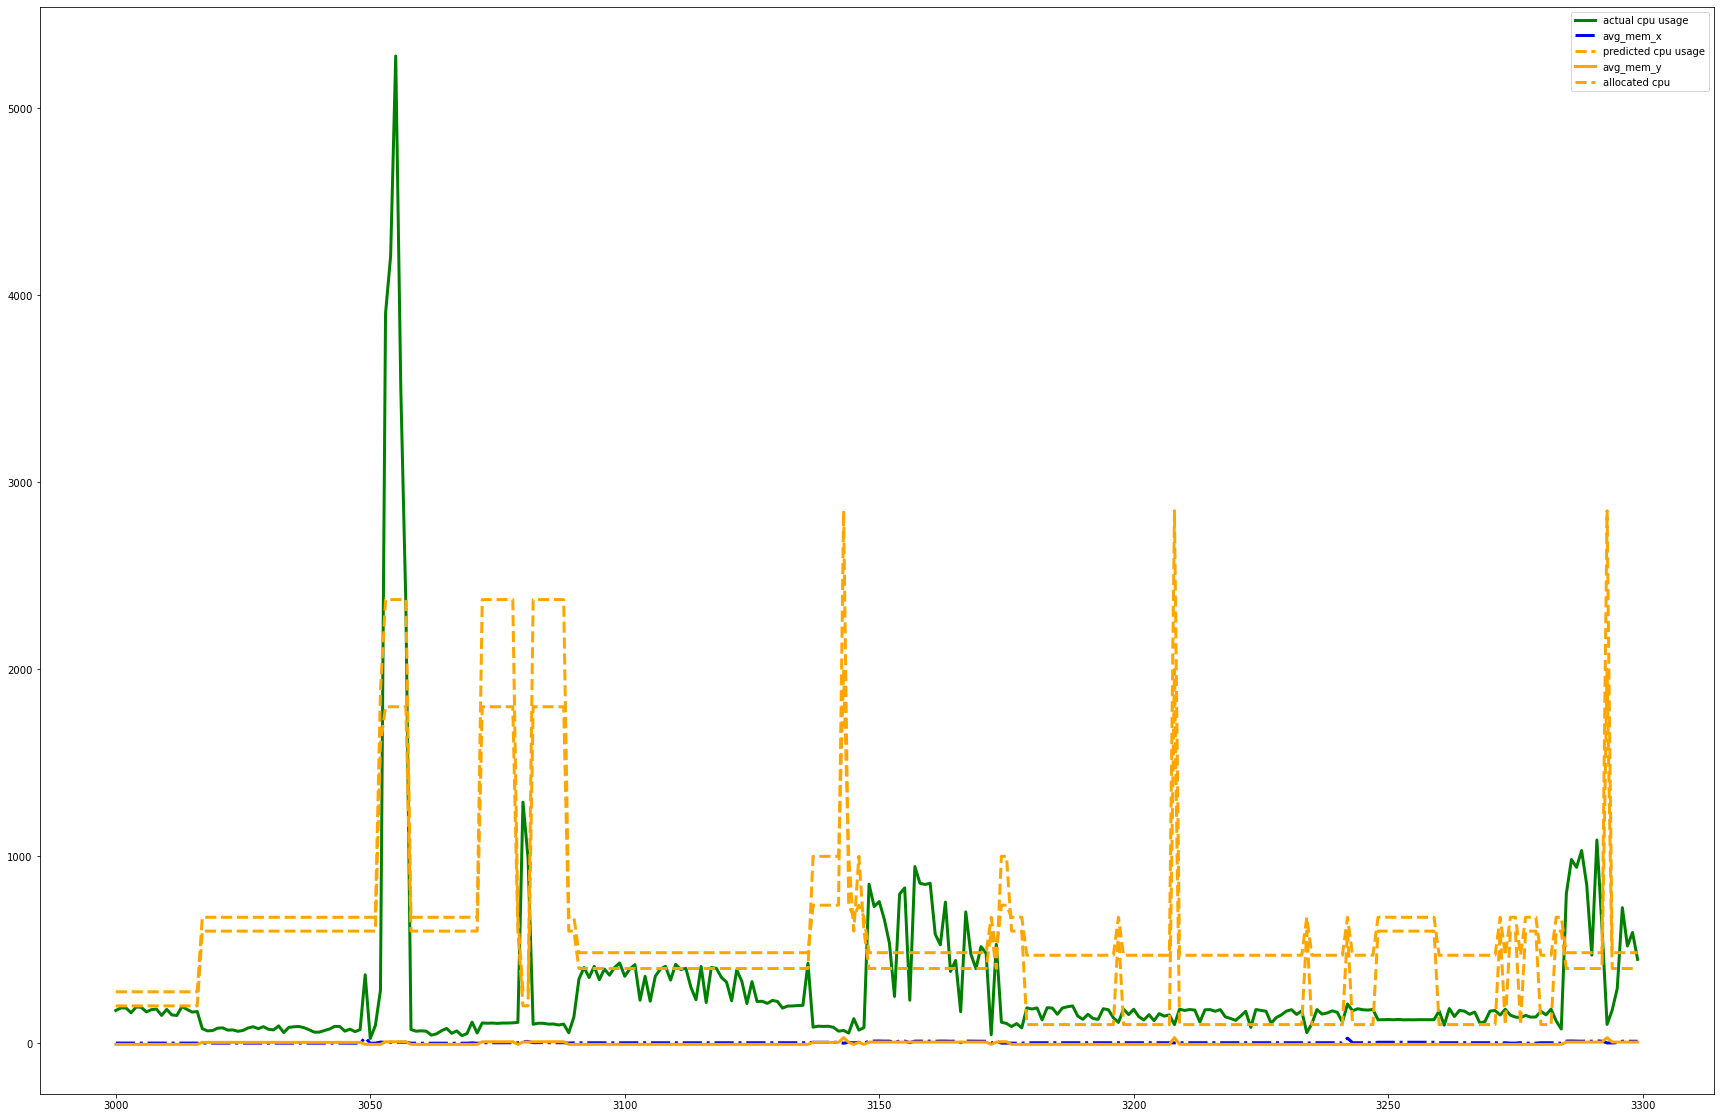

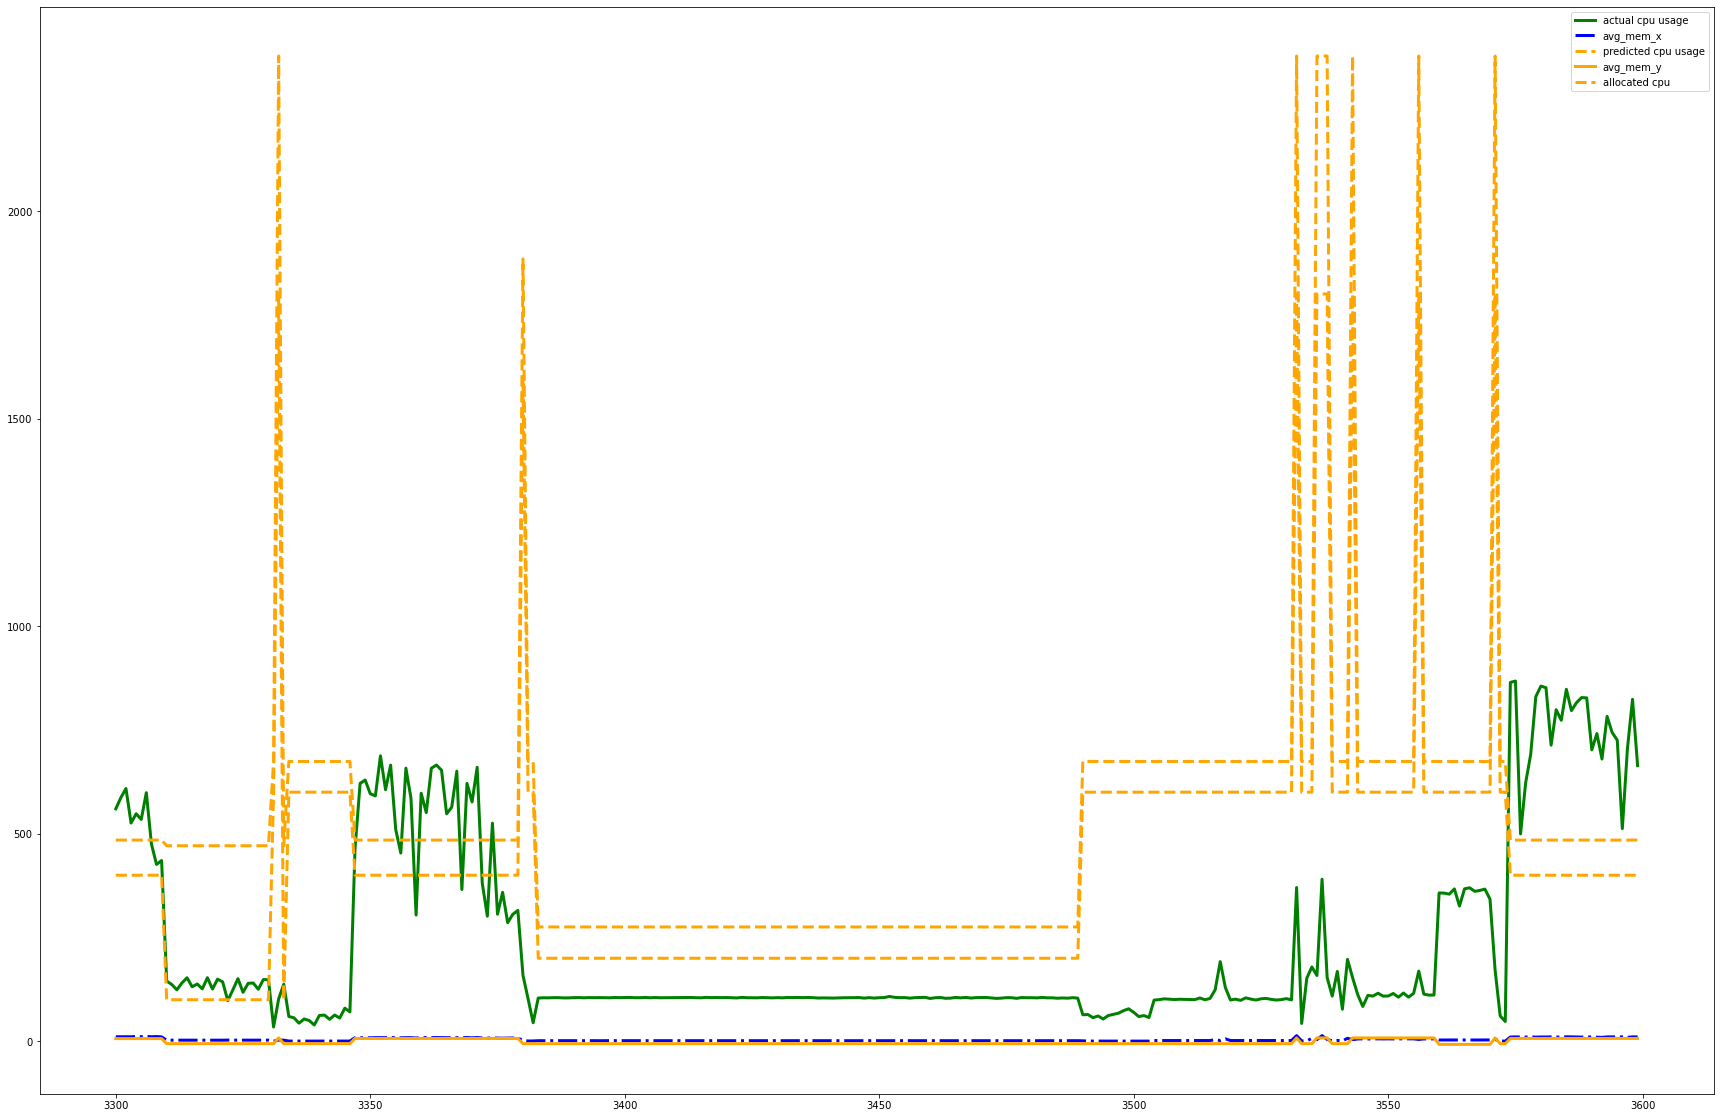

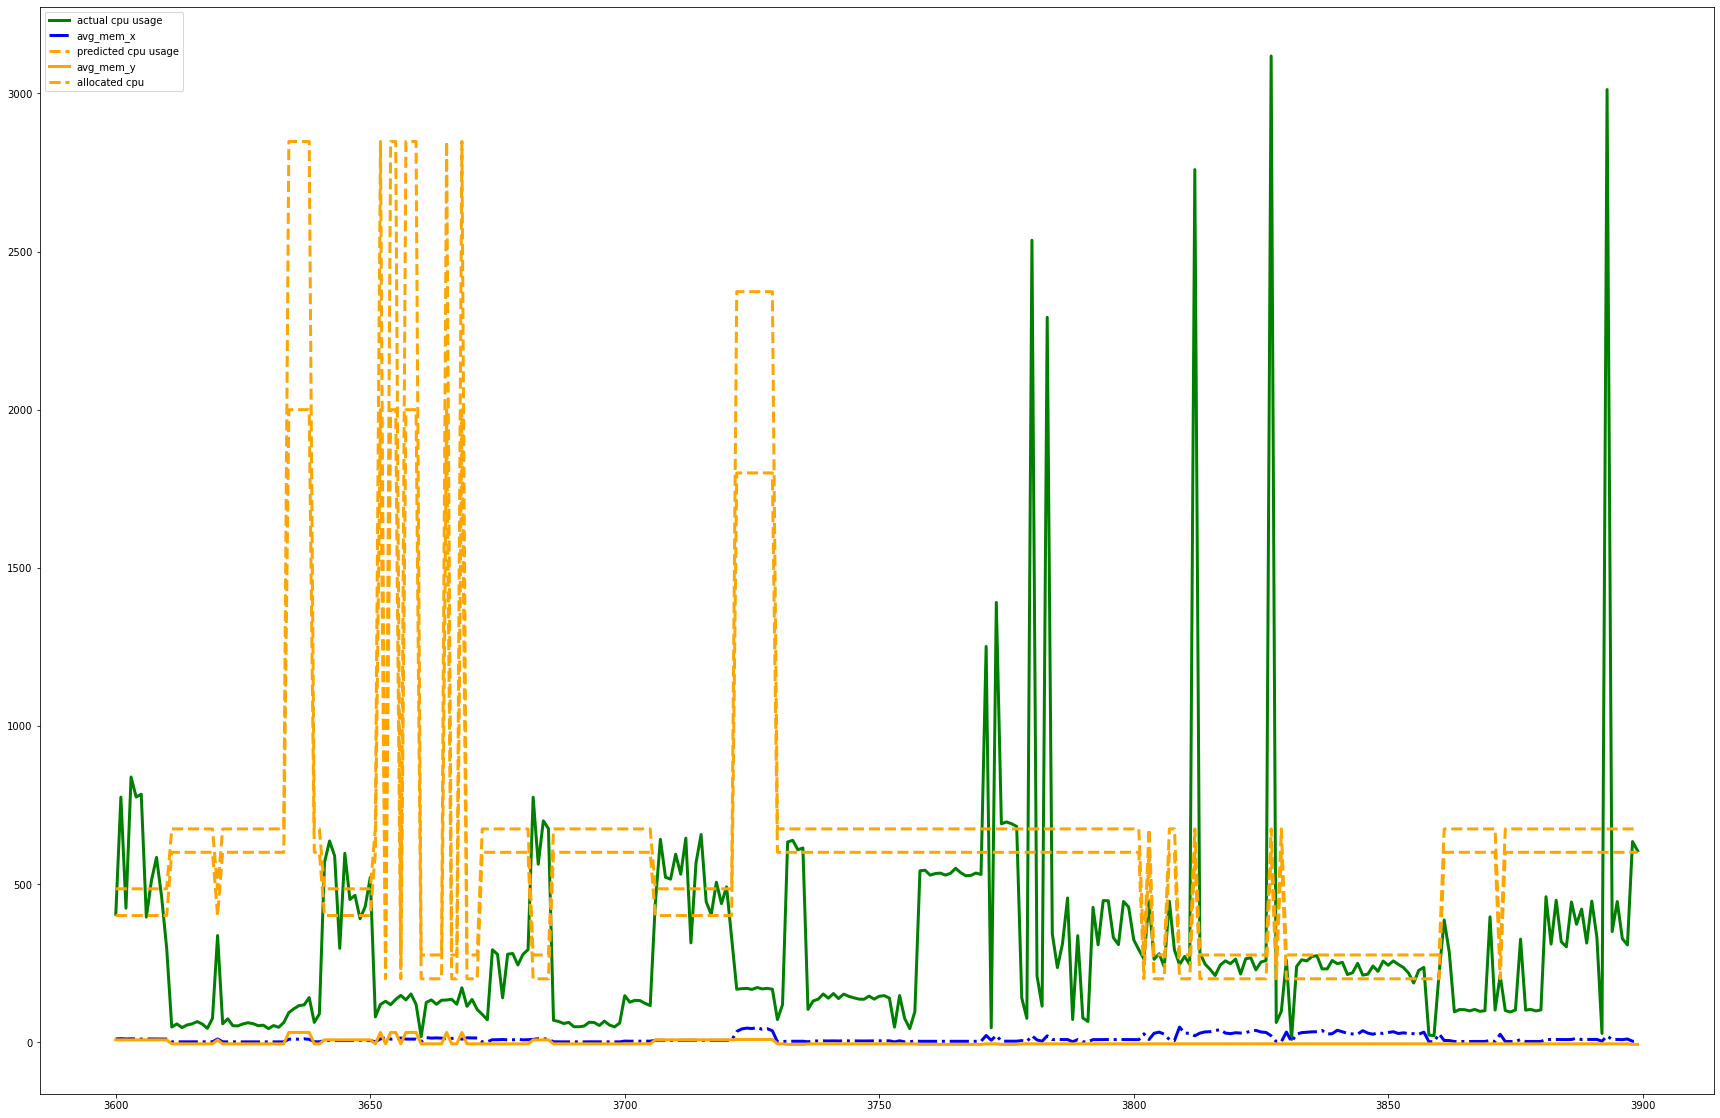

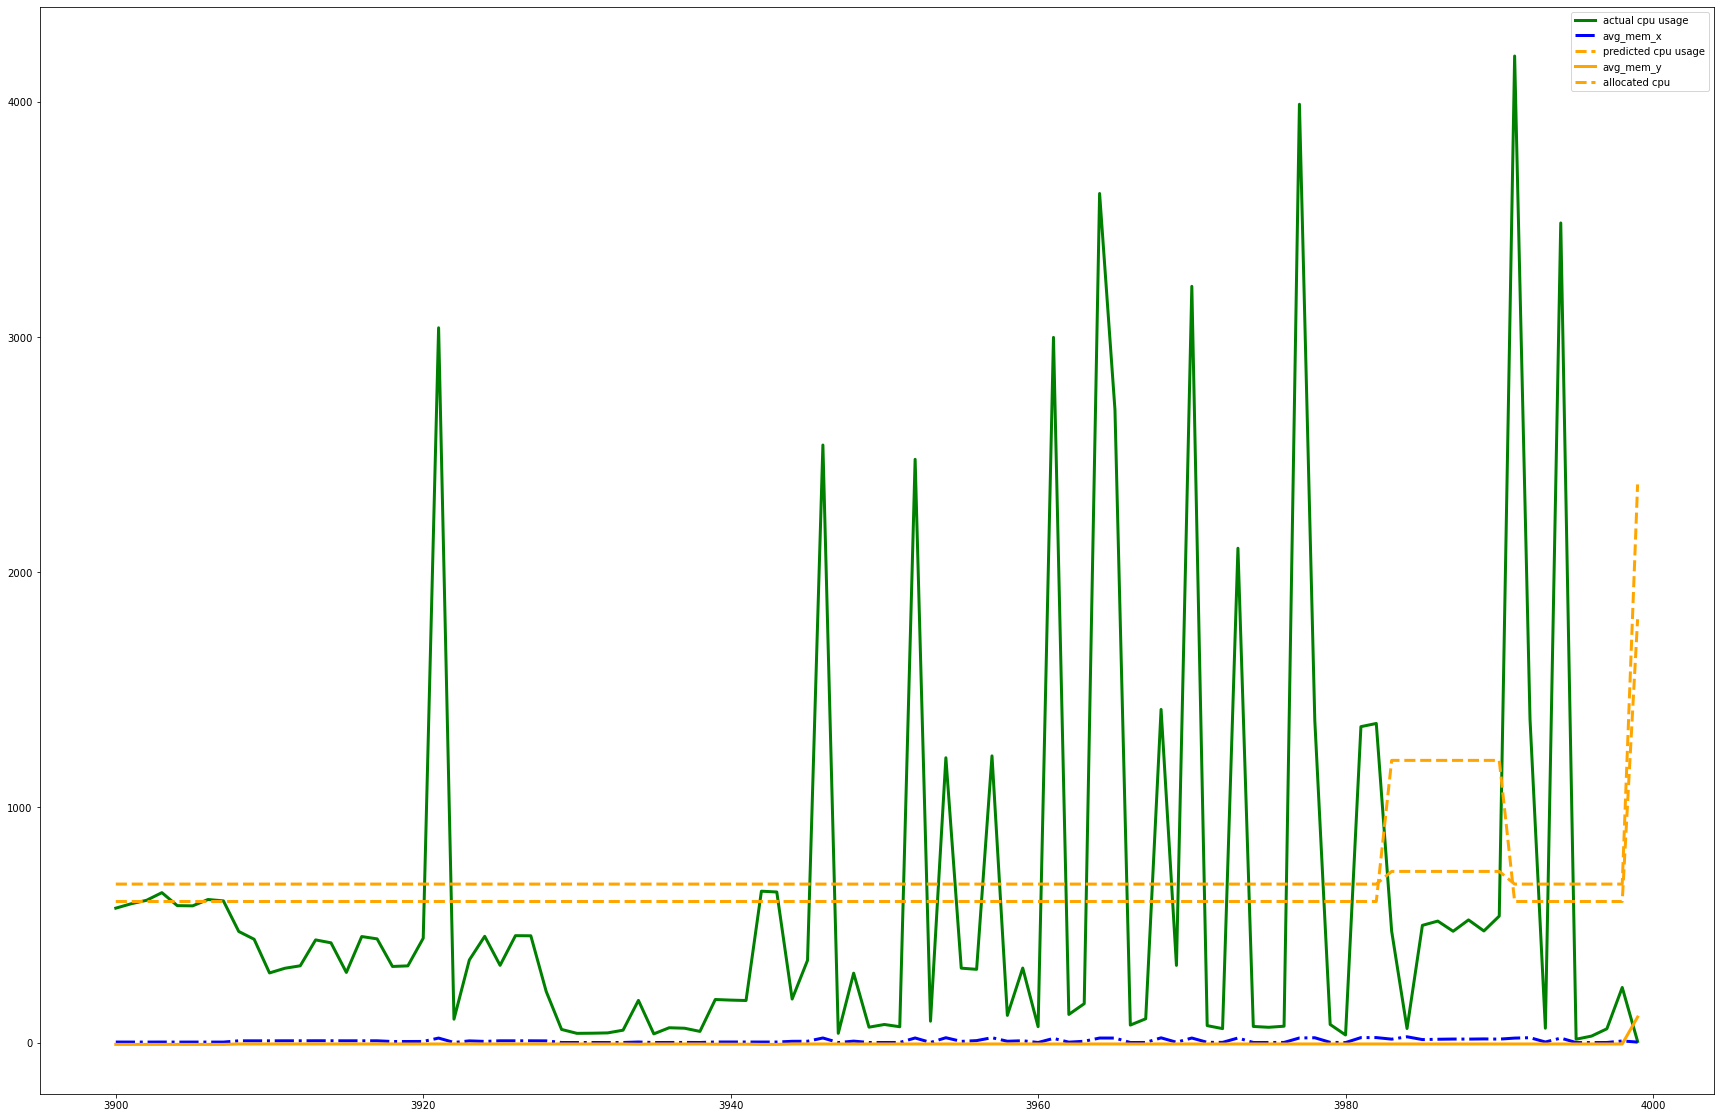

In [21]:
cycler = plt.cycler(linestyle=['-', '-.', '--', '-', '--', '-', '--'],
                    color=['green', 'blue', 'orange', 'orange', 'orange', 'green', 'green'],
)



# combined_df.iloc[250:500].plot(ax=ax, figsize=(30, 25), linewidth=2)


step: int = 1000
for i in range(0, len(combined_df), step):
    fig, ax = plt.subplots()
    ax.set_prop_cycle(cycler)
    # combined_df.iloc[i:i+step].plot.line(figsize=(30, 20), linewidth=3, ax=ax)
    plot = combined_df.iloc[i:i+step].plot
    plot.line(figsize=(30, 20), linewidth=3, ax=ax)

## Calculate Root Mean Squared Error

Calculating the RMSE for the overall prediction of the (training) dataset.

In [22]:
rmse_key: str = 'Root Mean Squared Error (Overall - Training)'
rmse_result = get_rmse(actual_data_df[:], prediction_df[:])
print(f'Test Score: {rmse_result:.2f} RMSE')
if INCLUDE_WANDB:
    wandb.summary[rmse_key] = rmse_result

Test Score: 584.80 RMSE


## Calculate Mean Absolute Error

Calcutlate the MAE for the overall prediction of the (training) dataset.

In [23]:
mae_key: str = 'Mean Absolute Error (Overall - Training)'
mae_result = mean_absolute_error(actual_data_df[:], prediction_df[:])
print(f'Test Score: {mae_result} MAE')

if INCLUDE_WANDB:
    wandb.summary[mae_key] = mae_result

Test Score: 294.03636761998933 MAE


In [24]:
def plot_column(actual_values=actual_data_df, predicted_values=prediction_df, column_number: int = 0, rmse_threshold: float = 0.30, is_training: bool = True):

    if len(label_columns) <= column_number:
        print('Out of Prediction Bounds')
        return

    plt.figure(figsize=(25, 15))  # plotting
    plt.rcParams.update({'font.size': 22})

    column = label_columns[column_number]
    pred_column = f"pred_{column}_{'training' if is_training else 'test'}"

    rmse = get_rmse(actual_values[column], predicted_values[column])
    mae = mean_absolute_error(actual_values[column], predicted_values[column])

    predicted_color = 'green' if rmse < rmse_threshold else 'orange'

    plt.plot(actual_values[column], label=column, color='black')  # actual plot
    plt.plot(predicted_values[column], label='pred_' +
             column, color=predicted_color)  # predicted plot

    plt.title('Time-Series Prediction')
    plt.plot([], [], ' ', label=f'RMSE: {rmse}')
    plt.plot([], [], ' ', label=f'MAE: {mae}')
    plt.legend()
    plt.ylabel('timeline', fontsize=25)
    
    if INCLUDE_WANDB:
        wandb.log({pred_column: wandb.Image(plt)})
        wandb.summary[f'Root Mean Squared Error ({column})'] = rmse
        wandb.summary[f'Mean Absolute Error ({column})'] = mae
        
    plt.show()


## See Predictions on Training Dataset

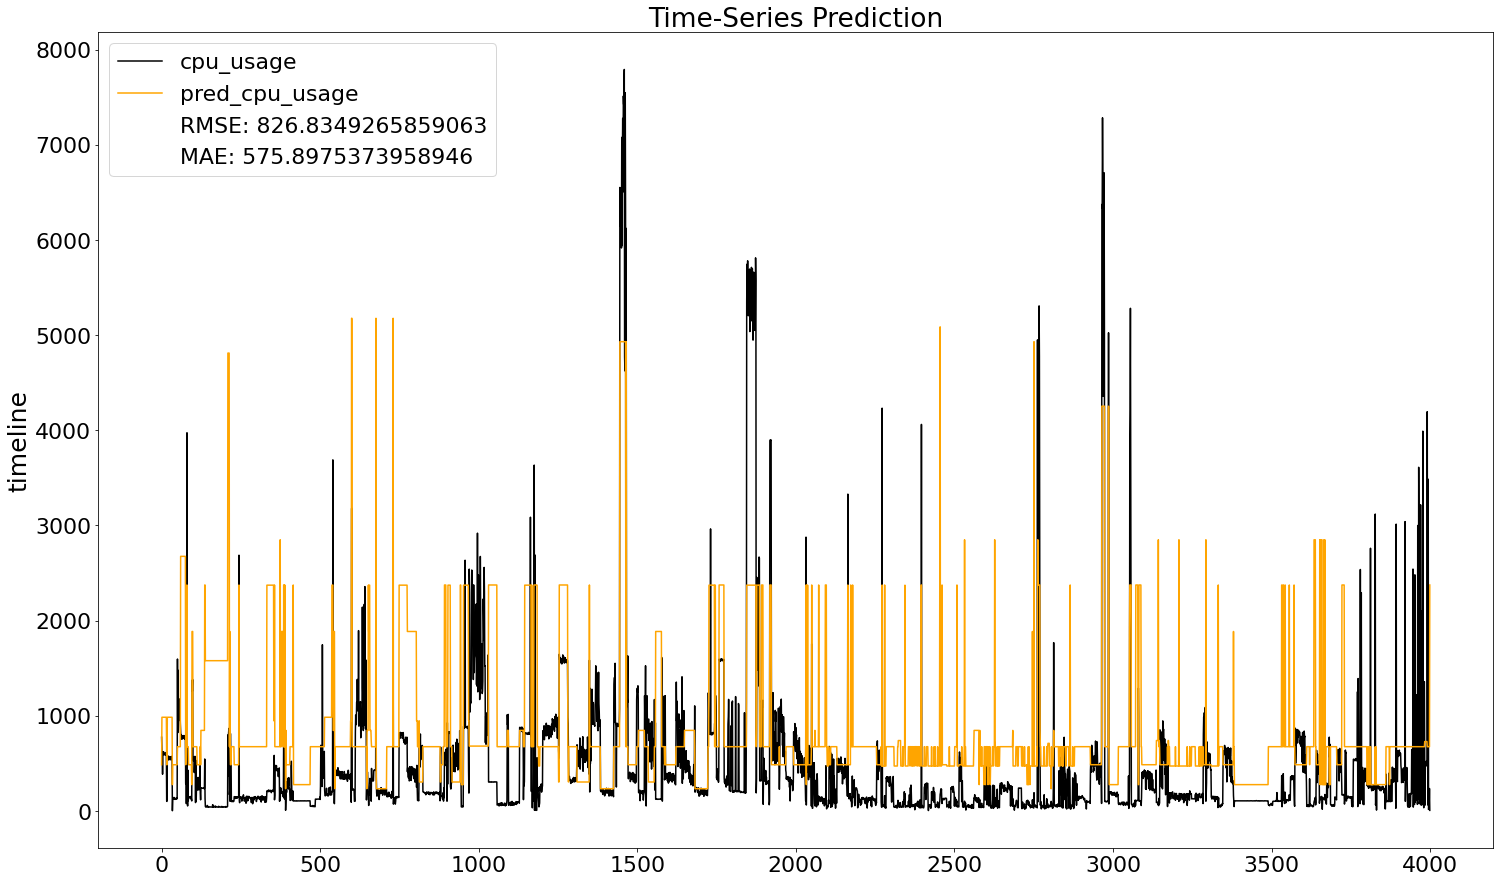

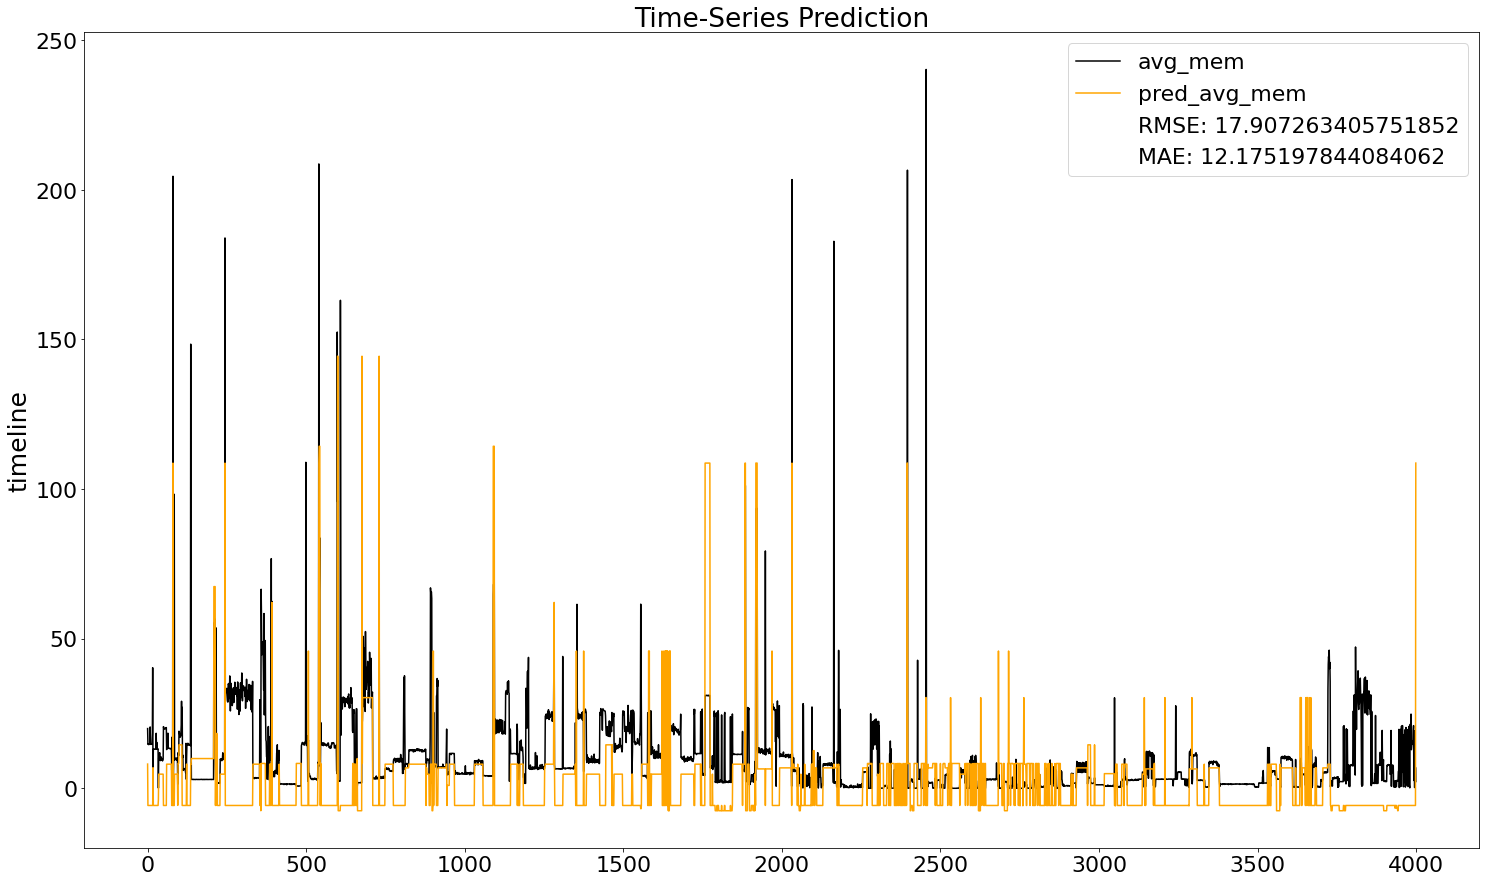

In [25]:
for idx in range(0, len(label_columns)):
    plot_column(actual_values=actual_data_df, predicted_values=prediction_df, column_number=idx)

In [26]:
# plot_column(actual_values=actual_data_df[7000:8000], predicted_values=prediction_df[7000:8000], column_number=0)

## Test Set Analysis

Below, the test set will be loaded and the model evaluated with it to see the actual performance.

In [27]:
# test_dataset = GPUDataset(is_training=False, small_df=True, batch_size=batch_size)

In [28]:
lstm.eval()

X_df = test_set.X
X_df = X_df.to(device)
# forward pass
prediction = lstm(X_df)
if get_device_as_string() == 'cuda' or get_device_as_string() == 'mps':
    prediction = prediction.cpu().data.numpy()
else:
    prediction = prediction.data.numpy()

actual_data = test_set.y.data.numpy()

label_columns = test_set._get_label_columns()

# create dataframes
prediction_df = pd.DataFrame(prediction, columns=label_columns)
actual_data_df = pd.DataFrame(actual_data, columns=label_columns)

# reverse transformation
prediction_df = dataset.y_scaler.inverse_normalization_df(prediction_df)
actual_data_df = dataset.y_scaler.inverse_normalization_df(actual_data_df)


In [29]:
test = test_set.X_scaler.convert_tensor_to_df(X_df)

In [30]:
test = test_set.X_scaler.inverse_standardize_df(test)
test = test[['plan_cpu']]
test

,plan_cpu
0,600.0
1,600.0
2,600.0
3,600.0
4,600.0
...,...
3995,600.0
3996,600.0
3997,600.0
3998,600.0


,cpu_usage,avg_mem,plan_cpu
0,34.159153,3.496461,600.0
1,35.678295,3.701090,600.0
2,34.351307,3.383132,600.0
3,33.209690,3.345555,600.0
4,32.212757,3.422899,600.0
...,...,...,...
3995,172.706177,9.332202,600.0
3996,739.335693,2.735355,600.0
3997,180.476349,9.647682,600.0
3998,173.821213,9.150590,600.0


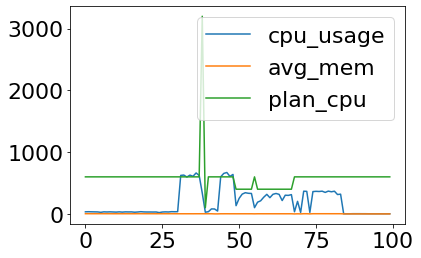

In [31]:
actual_data_df['plan_cpu'] = test['plan_cpu']
actual_data_df.iloc[0:100].plot.line()
actual_data_df

<AxesSubplot:>

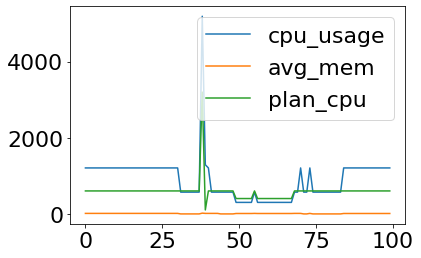

In [32]:
prediction_df['plan_cpu'] = test['plan_cpu']
prediction_df.iloc[0:100].plot.line()

In [33]:
bla = pd.merge(actual_data_df, prediction_df, left_index=True, right_index=True)
bla.drop(columns=['plan_cpu_y'], inplace=True)


<AxesSubplot:>

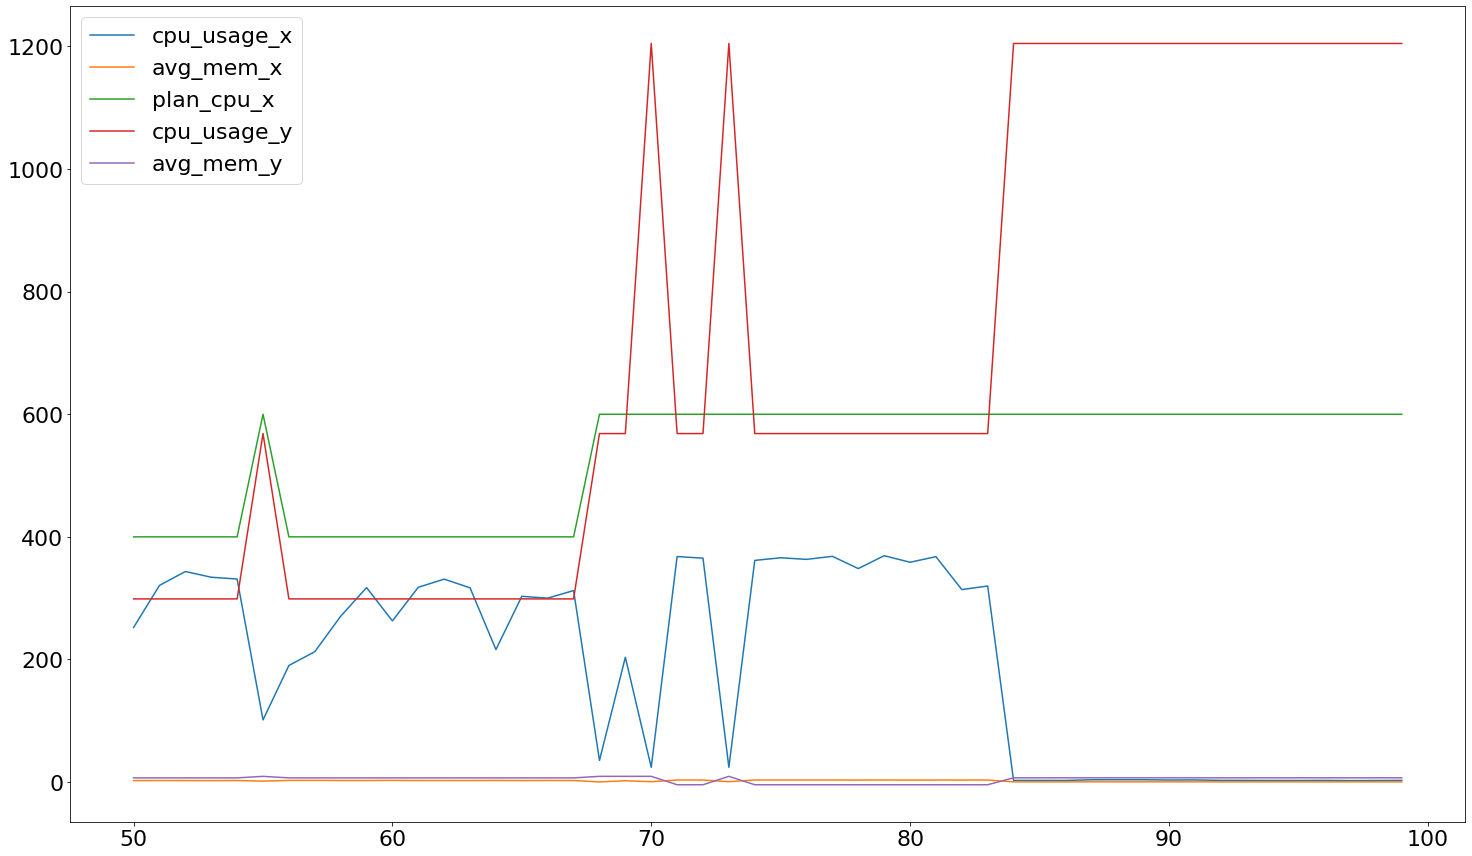

In [34]:

bla.iloc[50:100].plot.line(figsize=(25,15))

In [35]:
rmse_key: str = 'Root Mean Squared Error (Overall - Test)'
rmse_result = get_rmse(actual_data_df[:], prediction_df[:])
print(f'Test Score: {rmse_result:.2f} RMSE')

if INCLUDE_WANDB:
    wandb.summary[rmse_key] = rmse_result

Test Score: 569.55 RMSE


In [36]:
mae_key: str = 'Mean Absolute Error (Overall - Test)'
mae_result = mean_absolute_error(actual_data_df[:], prediction_df[:])
print(f'Test Score: {mae_result} MAE')
if INCLUDE_WANDB:
    wandb.summary[mae_key] = mae_result

Test Score: 216.04668312765784 MAE


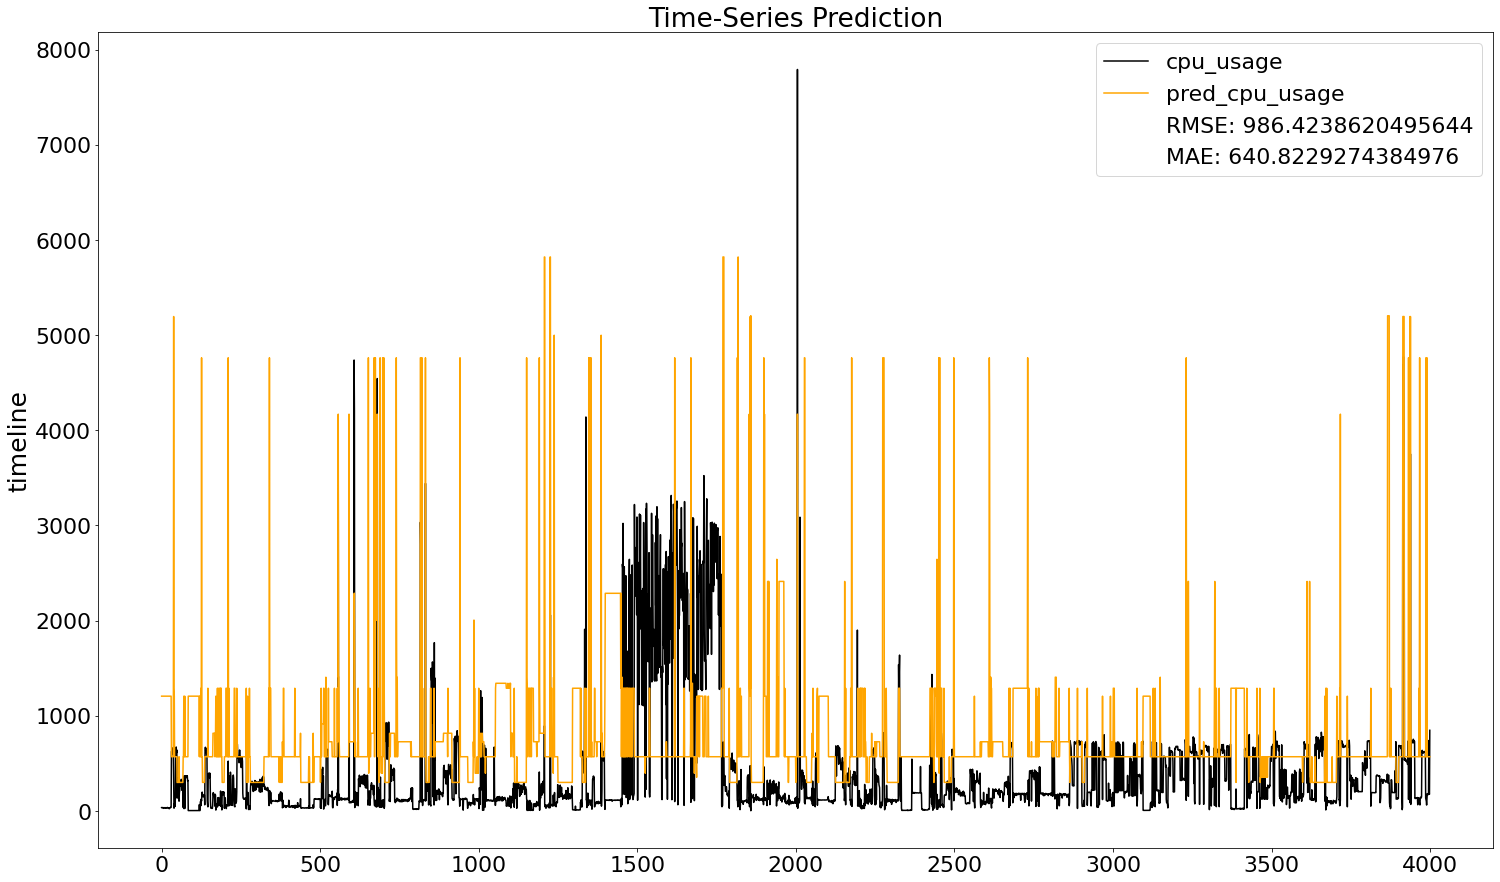

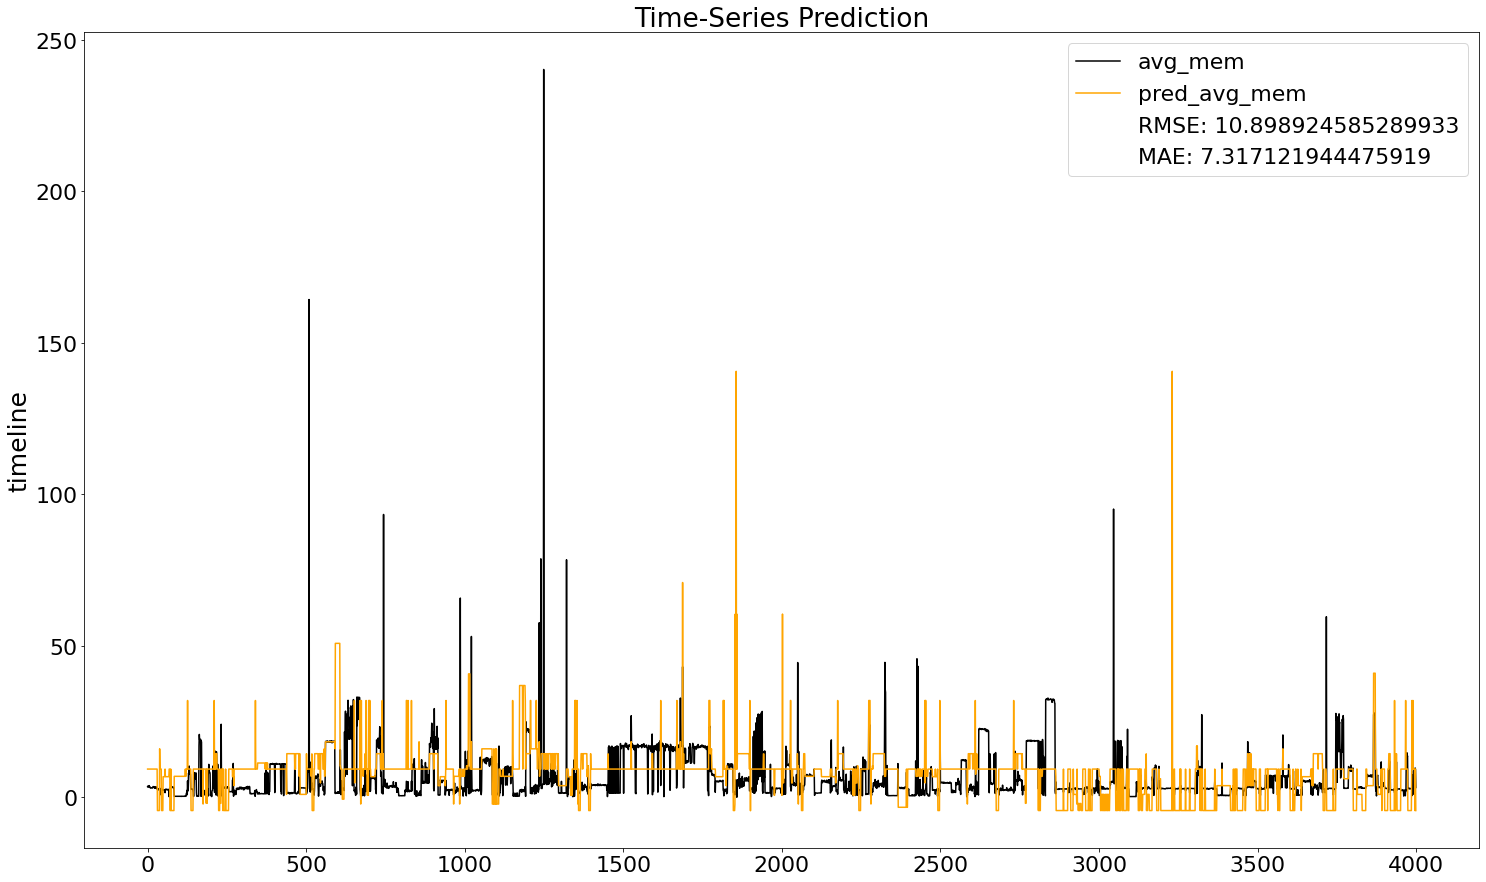

In [37]:
for idx in range(0, len(label_columns)):
    plot_column(actual_values=actual_data_df, predicted_values=prediction_df, column_number=idx)


In [38]:
# start_idx, end_idx = 9000, 10000
# plot_column(actual_values=actual_data_df[start_idx:end_idx], predicted_values=prediction_df[start_idx:end_idx], column_number=0)